# ****Построение модели, прогнозирующей стоимость автомобиля.****

В данной работе нам требуется "вытащить" данные с auto.ru, т.к train данных у нас нет. Совершить последующую работу с данными и спрогнозировать стоимость автомобилей.

**Выводы по работе и ее недостаткам в конце ноутбука.**

# 1. Импортируем все требуемые библиотеки:

In [67]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [68]:

import sys
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor
import xgboost as xgb
from bs4 import BeautifulSoup    
import requests 
import matplotlib.pyplot as plt
import seaborn as sns

#import pandas_profiling
#from pandas_profiling import ProfileReport

from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, PolynomialFeatures

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from pandas import Series

from sklearn.metrics import recall_score, make_scorer
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.base import clone
import datetime
from datetime import datetime, timedelta
import math

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import BaggingRegressor, StackingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from pprint import pprint

!pip freeze > requirements.txt

RANDOM_SEED = 42


# 2. Предварительный осмотр тестовых данных:

Так как в данном соревновании мы обладаем только тестовыми данными, то прибегнем к парсингу данных, чтобы получить тренировочные данные, на которых мы будем обучать нашу модель. Для того, чтобы в общих чертах оценить требуемые признаки, рассмотрим имеющиеся тестовые данные.

In [69]:
#DIR_TEST   = '../input/sf-dst-car-price-prediction/'
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [70]:
test.sample(5)

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
28548,внедорожник 5 дв.,MITSUBISHI,https://auto.ru/cars/used/sale/mitsubishi/paje...,бежевый,NaN,Есть небольшая коррозия по кузову. Магнитола п...,3.5 LTR,202 N12,"{""tinted-glass"":true,""aux"":true,""usb"":true,""au...",бензин,https://autoru.naydex.net/mcQh17801/f1b5751dCi...,329000,2002,"{""code"":""PAJERO"",""name"":""Pajero"",""ru_name"":""Па...",PAJERO,3.5 AT (202 л.с.) 4WD,5,1603266880,RUB,2004,1100619836,"{""id"":""21834665"",""displacement"":3497,""engine_t...",ALLROAD_5_DOORS AUTOMATIC 3.5,автоматическая,JAPANESE,2 владельца,7 лет и 7 месяцев,Оригинал,полный,Левый,Не требует ремонта,Растаможен
16952,внедорожник 5 дв.,MERCEDES,https://auto.ru/cars/used/sale/mercedes/m_klas...,белый,NaN,"Отличный семейный автомобиль, есть незначитель...",3.0 LTR,224 N12,NaN,дизель,https://avatars.mds.yandex.net/get-autoru-vos/...,200000,2008,"{""code"":""M_KLASSE"",""name"":""M-Класс"",""ru_name"":...",M_KLASSE,350 3.0d AT (224 л.с.) 4WD,5,1603245872,RUB,2010,1100164272,"{""id"":""2307886"",""name"":""350"",""nameplate"":""350""...",ALLROAD_5_DOORS AUTOMATIC 3.0,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен
25434,внедорожник 5 дв.,VOLKSWAGEN,https://auto.ru/cars/used/sale/volkswagen/tigu...,серебристый,"{""id"":""20364043"",""name"":""Trend&Fun"",""available...","Авто в хорошем состоянии, владею им 6 лет. Два...",1.4 LTR,122 N12,"{""tinted-glass"":true,""esp"":true,""heated-wash-s...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,196000,2011,"{""code"":""TIGUAN"",""name"":""Tiguan"",""ru_name"":""Ти...",TIGUAN,1.4 MT (122 л.с.),5,1603221395,RUB,2011,1088514386,"{""id"":""7344487"",""displacement"":1390,""engine_ty...",ALLROAD_5_DOORS MECHANICAL 1.4,механическая,EUROPEAN,2 владельца,7 лет и 4 месяца,Оригинал,передний,Левый,Не требует ремонта,Растаможен
34317,седан,MITSUBISHI,https://auto.ru/cars/used/sale/mitsubishi/lanc...,серый,NaN,"Машиной владею в районе года, пробег на машине...",1.6 LTR,98 N12,"{""electro-window-back"":true,""asr"":true,""tinted...",бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,185000,2005,"{""code"":""LANCER"",""name"":""Lancer"",""ru_name"":""Ла...",LANCER,1.6 AT (98 л.с.),4,1603678699,RUB,2005,1101362959,"{""id"":""3480641"",""displacement"":1584,""engine_ty...",SEDAN AUTOMATIC 1.6,автоматическая,JAPANESE,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
27820,седан,MITSUBISHI,https://auto.ru/cars/used/sale/mitsubishi/lanc...,чёрный,NaN,Лансер 10 показывает себя как надежный авто: ...,1.8 LTR,143 N12,"{""engine-proof"":true,""electro-window-back"":tru...",бензин,https://autoru.naydex.net/mcQh17801/f1b5751dCi...,180000,2007,"{""code"":""LANCER"",""name"":""Lancer"",""ru_name"":""Ла...",LANCER,1.8 CVT (143 л.с.),4,1603264127,RUB,2007,1101167322,"{""id"":""20097140"",""displacement"":1798,""engine_t...",SEDAN VARIATOR 1.8,вариатор,JAPANESE,3 или более,4 года и 4 месяца,Оригинал,передний,Левый,Не требует ремонта,Растаможен


**Описание признаков в тестовом датасете:**
- `bodyType` - тип кузова
- `brand` - марка автомобиля
- `car_url` - сайт с объявлением
- `color` - цвет автомобиля
- `complectation_dict` - словарь с версией пакета комплектации автомобиля
- `description` - дополнительное описание автомобиля / объявления
- `engineDisplacement` - объем двигателя
- `enginePower` - мощность двигателя
- `equipment_dict` - словарь с комплектацией автомобиля
- `fuelType` - тип топлива
- `image` - изображение
- `mileage` - пробег
- `modelDate` - год выпуска модели
- `model_info` - информация о модели в оригинале и по-русски
- `model_name` - название модели
- `name` - означение объема и типа двигателя, мощность в лошадиных силах
- `numberOfDoors` - кол-во дверей
- `parsing_unixtime` - дата парсинга данных
- `priceCurrency` - валюта
- `productionDate` - год производства
- `sell_id` - код (ID) продавца
- `super_gen` - словарь с технической характеристикой автомобиля
- `vehicleConfiguration` - кузов, количество дверей и объем двигателя транспортного средства
- `vehicleTransmission` - тип коробки передачи
- `vendor` - регион изготовителя: Европа или Япония
- `Владельцы` - кол-во владельцев
- `Владение` - срок владения
- `ПТС` - тип документа: оригинал или дупликат
- `Привод` - тип привода
- `Руль` - размещение руля
- `Состояние` - информация о том, требует ли ремонта автомобиль
- `Таможня` - информация о том, растаможено ли авто

In [71]:
# Profile = ProfileReport(test)
# Profile

**После использования PandasProfiling можно сделать выводы:**
1) 27 категориальных и 5 числовых данных.

2) Больше всего седанов, чуть меньше внедорожников.

3) В разделе с ссылками нет одинаковых элементов.

4) Самый популярный цвет - черный.

5) В столбце с описанием версии комплектации автомобиля 81.5% пропущенных данных.

6) Похожая ситуация в столбце с комплектующими авто - 28.8% пропущенных значений.

7) Большинство автомобилей на бензине.

8) Некоторые картинки автомобилей повторяются.

9) 75% автомобилей младше 2004 года.

10) Больше всего 5-дверок.

11) У каждого автомобиля есть техническая характеристика.

12) Больше всего автомобилей с 3 и более владельцами.

13) 65.4% процента информации не указано в столбце "Владение".

- Сильная корреляция выявлена между milleage, modelDate и productionDate.


# 3. Парсинг данных:

Парсинг данных с auto.ru был совершен с помощью скрипта:

In [72]:
# import argparse
# from collections import namedtuple, defaultdict
# from csv import DictWriter
# import json
# from pathlib import Path

# import requests
# from loguru import logger

# columns = ['bodyType', 'brand', 'car_url', 'color', 'complectation_dict', 'description', 'engineDisplacement',
#            'enginePower', 'location',
#            'equipment_dict', 'fuelType', 'image', 'mileage', 'modelDate', 'model_info', 'model_name', 'name',
#            'numberOfDoors', 'parsing_unixtime', 'priceCurrency', 'productionDate', 'sell_id', 'super_gen',
#            'vehicleConfiguration', 'vehicleTransmission', 'vendor', 'Владельцы', 'Владение', 'ПТС', 'Привод',
#            'Руль', 'Состояние', 'Таможня', 'price']

# CarInfo = namedtuple('Car', columns)

# brand_in_test = {
#     'BMW': 4473,
#     'VOLKSWAGEN': 4404,
#     'NISSAN': 4393,
#     'MERCEDES': 4180,
#     'TOYOTA': 3913,
#     'AUDI': 3421,
#     'MITSUBISHI': 2843,
#     'SKODA': 2741,
#     'VOLVO': 1463,
#     'HONDA': 1150,
#     'INFINITI': 871,
#     'LEXUS': 834
# }
# cars_in_test = sum(val for val in brand_in_test.values())
# proportion_in_test = {key: val / cars_in_test for key, val in brand_in_test.items()}


# def get_headers():
#     headers = '''
# Host: auto.ru
# Connection: keep-alive
# Content-Length: 99
# x-requested-with: fetch
# x-client-date: 1603066469874
# x-csrf-token: c23073bb4cd65413662a41bd460fd8317459fe3ce6d83db1
# x-page-request-id: 3c4800b60eb9e8c568e5a515f5cd4872
# content-type: application/json
# User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/86.0.4240.75 Safari/537.36
# x-client-app-version: 202010.16.122434
# Accept: */*
# Origin: https://auto.ru
# Sec-Fetch-Site: same-origin
# Sec-Fetch-Mode: same-origin
# Sec-Fetch-Dest: empty
# Referer: https://auto.ru/cars/bmw/all/?output_type=list&page=1
# Accept-Encoding: gzip, deflate, br
# Accept-Language: ru-RU,ru;q=0.9,en-US;q=0.8,en;q=0.7
# Cookie: autoru_sid=a%3Ag5f88f7d72b1bif6t0m99h0krigjgs2e.a783a85b576c8a7acaea4faafaa81ffc%7C1602811863959.604800.QhhqH0HWfM4BPWrsvjyfIg.8EXrpUR7Bq1a2gOSCnsb0HnXxvmHbYB9eF5Uz5o_bZE; autoruuid=g5f88f7d72b1bif6t0m99h0krigjgs2e.a783a85b576c8a7acaea4faafaa81ffc; suid=63abf8672f4a9e550bb96dd00b95ad21.8e155bfb838a5227bdd9dea1d2cbdc3e; _ym_uid=1602811867719278329; yuidcs=1; crookie=PZwS3/iYq2PFIw/dbrsqDVB/0e2v79Xe/8RsG6ySC8Djcl+mh/UCjYohgODaSkw7rMa6O9v7+RD56YSQKE2fhSkWxV8=; cmtchd=MTYwMjgyODMxMjMwNQ==; bltsr=1; yuidlt=1; yandexuid=360949521578055883; my=YwA%3D; _ym_isad=1; promo-app-banner-shown=1; promo-header-counter=4; _csrf_token=c23073bb4cd65413662a41bd460fd8317459fe3ce6d83db1; from=direct; X-Vertis-DC=myt; _ym_wasSynced=%7B%22time%22%3A1603066366683%2C%22params%22%3A%7B%22eu%22%3A0%7D%2C%22bkParams%22%3A%7B%7D%7D; gdpr=0; _ym_visorc_22753222=b; from_lifetime=1603066463083; _ym_d=1603066470'''
#     headers = {line.split(': ')[0]: line.split(': ')[1] for line in headers.strip().split('\n')}
#     return headers


# def get_data_from_site(pange_num: int, brand: str) -> dict:
#     """ получает данные о тачках БМВ с авто.ру, номер страницы передан в параметре page_num
#     возвращает полученный с сайта json """

#     base_url = 'https://auto.ru/-/ajax/desktop/listing/'
#     params = dict(category='cars', section="all", output_type="list", page=pange_num,
#                   catalog_filter=[{'mark': brand}], geo_id=[213], geo_radius=800)
#     r = requests.post(base_url, json=params, headers=get_headers())
#     r.raise_for_status()
#     return r.json()


# def add_car_data(car_data: list, data_json: dict):
#     """ разбирает данные из переданного объекта data_json
#     из массива offers, формирует объекты CarInfo и
#     добавляет их в список car_data"""

#     if 'offers' not in data_json:
#         return

#     for car in data_json['offers']:
#         if 'configuration' not in car['vehicle_info']:
#             continue

#         body_type_human = car['vehicle_info']['configuration']['human_name']
#         body_type = car['vehicle_info']['configuration']['body_type']
#         transmission = car['vehicle_info']['tech_param']['transmission']
#         engine_volume = car['vehicle_info']['tech_param']['displacement']
#         engine_volume = round(float(engine_volume) / 1000, 1)

#         try:
#             purchase_date = car['documents']['purchase_date']
#         except KeyError:
#             purchase_date = None

#         try:
#             owners_number = car['documents']['owners_number']
#         except KeyError:
#             owners_number = None

#         try:
#             description = car['description']
#         except KeyError:
#             description = None
#         try:
#             pts = car['documents']['pts']
#         except KeyError:
#             pts = None
#         try:
#             price = car['price_info']['RUR']
#         except KeyError:
#             continue

#         brand = car['vehicle_info']['mark_info']['name']
#         model = car['vehicle_info']['model_info']['name']
#         sell_id = car['saleId']
#         section = car['section']
#         car_url = f'https://auto.ru/cars/{section}/sale/{brand.lower()}/{model.lower()}/{sell_id}/'

#         info = CarInfo(bodyType=body_type_human,
#                        brand=brand,
#                        car_url=car_url,
#                        image=car['state']['image_urls'][0]['sizes']['small'],
#                        color=car['color_hex'],
#                        complectation_dict=car['vehicle_info']['complectation'],
#                        equipment_dict=car['vehicle_info']['equipment'],
#                        model_info=car['vehicle_info']['model_info'],
#                        model_name=model,
#                        location=car['seller']['location']['region_info']['name'],
#                        parsing_unixtime=car['additional_info']['fresh_date'],
#                        priceCurrency=car['price_info']['currency'],
#                        sell_id=sell_id,
#                        super_gen=car['vehicle_info']['super_gen'],
#                        vendor=car['vehicle_info']['vendor'],
#                        fuelType=car['vehicle_info']['tech_param']['engine_type'],
#                        modelDate=car['vehicle_info']['super_gen']['year_from'],
#                        name=car['vehicle_info']['tech_param']['human_name'],
#                        numberOfDoors=car['vehicle_info']['configuration']['doors_count'],
#                        productionDate=car['documents']['year'],
#                        vehicleConfiguration=body_type + " " + transmission + " " + str(engine_volume),
#                        vehicleTransmission=transmission,
#                        engineDisplacement=str(engine_volume) + ' LTR',
#                        enginePower=str(car['vehicle_info']['tech_param']['power']) + ' N12',
#                        description=description,
#                        mileage=car['state']['mileage'],
#                        Привод=car['vehicle_info']['tech_param']['gear_type'],
#                        Руль=car['vehicle_info']['steering_wheel'],
#                        Состояние=car['state']['state_not_beaten'],
#                        Владельцы=owners_number,
#                        ПТС=pts,
#                        Таможня=car['documents']['custom_cleared'],
#                        Владение=purchase_date,
#                        price=price
#                        )
#         car_data.append(info)


# def write_to_csv(car_data: list, output_folder_path: Path, page_num: int):
#     """Записывает информацию о машинах из car_data в файл формата csv
#     output_folder_path задает папку для сохранения
#     page_num - нужен для наименования файла"""

#     if not car_data:
#         return

#     filename = output_folder_path / f'train_{page_num}.csv'
#     with open(filename, 'w', encoding='utf-8', newline='') as f:
#         logger.info(f'writing {filename}, содержащий {len(car_data)} записей')
#         writer = DictWriter(f, fieldnames=columns)
#         writer.writeheader()
#         writer.writerows([car._asdict() for car in car_data])


# def pickup_brand(brand_stats: dict) -> str:
#     cars_count = sum(val for val in brand_stats.values())
#     brand_proportion = {key: val / cars_count for key, val in brand_stats.items()}

#     proportion_in_test_copy = proportion_in_test.copy()
#     for key, val in brand_proportion.items():
#         proportion_in_test_copy[key] -= val

#     return sorted(proportion_in_test_copy.items(),
#                   key=lambda x: x[1],
#                   reverse=True)[0][0] # first element, key of pair key:value


# def parse_data(n_pages, output_folder, save_json, json_folder):
#     """Входная точка в программу. Содержит верхнеуровневую логику.
#     Собирает информацию с сайта, парсит и сохраняет в формате csv"""

#     logger.info('Starting parse data from auto.ru about cars')

#     if save_json:
#         json_folder_path = Path(json_folder)
#         json_folder_path.mkdir(parents=True, exist_ok=True)

#     output_folder_path = Path(output_folder)
#     output_folder_path.mkdir(parents=True, exist_ok=True)

#     car_data = []
#     brand_stats = defaultdict(lambda: 1)

#     for page_num in range(1, n_pages + 1):

#         brand = pickup_brand(brand_stats)

#         logger.info(f'processing page: {page_num} {brand} {brand_stats[brand]}')
#         try:
#             data_json = get_data_from_site(brand_stats[brand], brand)
#         except Exception as e:
#             logger.error(f"Error in parsing: {e}")
#             continue

#         brand_stats[brand] += 1

#         if save_json:
#             with open(json_folder_path / f'page_{page_num}.json', 'w', encoding='utf-8') as f:
#                 json.dump(data_json, f)

#         add_car_data(car_data, data_json)

#         if page_num % 50 == 0:
#             write_to_csv(car_data, output_folder_path, page_num)
#             car_data = []

#     write_to_csv(car_data, output_folder_path, page_num)

#     logger.info('parsing successfully finished')


# def main():
#     parser = argparse.ArgumentParser()
#     parser.add_argument("n_pages", help="number of pages to parse", type=int)
#     parser.add_argument("-o", "--output_folder", help='folder to save parsed csv files', type=str, default='.')
#     parser.add_argument("-j", "--save_json", help="save json files", action="store_true")
#     parser.add_argument("--json_folder", help='folder for json files', type=str, default='json')
#     args = parser.parse_args()

#     parse_data(args.n_pages,
#                args.output_folder,
#                args.save_json,
#                args.json_folder)


# if __name__ == '__main__':
#     main()

Данный скрипт был запущен из консоли Windows с помощью команды:

`python autoru_parser.py 1000 -o train_folder`

Далее мы смогли получить множество csv файлов в нашей корневой папке, названной `train_folder`. Эти файлы были объединены в локальном ноутбуке Jupyter-Notebook с помощью кода:
```
import os
import pandas as pd
TRAIN_FOLDER_PATH = "train_folder"
df_train = []
for file_name in os.listdir(TRAIN_FOLDER_PATH):
    df_train.append(pd.read_csv(os.path.join(TRAIN_FOLDER_PATH,file_name)))
df = pd.concat(df_train)
df.to_csv('parsed.csv')
```
Было получено 673278 строчек. 

Далее в правом разделе Kaggle-ноутбука с помощью `Add data` мы смогли загрузить наши данные.

In [73]:
train = pd.read_csv('parsed.csv')

# 4. Предварительная обработка данных:

In [74]:
train.sample(3)

,Unnamed: 0,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,location,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня,price
551131,1803,Внедорожник 5 дв.,BMW,https://auto.ru/cars/used/sale/bmw/x3/11054802...,040001,{'id': '0'},Автомобиль приобретался у официального дилера ...,2.0 LTR,190 N12,Москва,"{'cruise-control': True, 'asr': True, 'tinted-...",DIESEL,//avatars.mds.yandex.net/get-autoru-vos/523244...,88750,2017,"{'code': 'X3', 'name': 'X3', 'ru_name': 'Х3', ...",X3,20d xDrive 2.0d AT (190 л.с.) 4WD,5,1637062483464,RUR,2018,1105480206-7f1a36db,"{'id': '21029610', 'name': 'III (G01)', 'ru_na...",ALLROAD_5_DOORS AUTOMATIC 2.0,AUTOMATIC,EUROPEAN,2.0,NaN,ORIGINAL,ALL_WHEEL_DRIVE,LEFT,True,True,3250000
212207,1665,Минивэн,Volkswagen,https://auto.ru/cars/used/sale/volkswagen/mult...,040001,"{'id': '20982256', 'name': 'Highline', 'availa...",Автомобиль был куплен новым у официального дил...,2.0 LTR,180 N12,Москва,"{'cruise-control': True, 'tinted-glass': True,...",DIESEL,//avatars.mds.yandex.net/get-autoru-vos/555326...,138000,2015,"{'code': 'MULTIVAN', 'name': 'Multivan', 'ru_n...",Multivan,2.0d AMT (180 л.с.) 4WD,4,1637078264292,RUR,2016,1105669895-7cdfadaf,"{'id': '20580298', 'name': 'T6', 'ru_name': 'Т...",MINIVAN ROBOT 2.0,ROBOT,EUROPEAN,3.0,"{'year': 2016, 'month': 12}",ORIGINAL,ALL_WHEEL_DRIVE,LEFT,True,True,3290000
249234,203,Седан,Audi,https://auto.ru/cars/new/sale/audi/a6/11053071...,97948F,"{'id': '21793195', 'name': 'Advance 40 TFSI S ...",Trade-In: -200 000 руб.\nЛизинг: -150 000 руб....,2.0 LTR,190 N12,Москва,"{'cruise-control': True, 'asr': True, 'esp': T...",GASOLINE,//avatars.mds.yandex.net/get-autoru-vos/494461...,0,2018,"{'code': 'A6', 'name': 'A6', 'ru_name': 'А6', ...",A6,40 TFSI 2.0 AMT (190 л.с.),4,1635838927000,RUR,2021,1105307125-6a5fce11,"{'id': '21210593', 'name': 'V (C8)', 'ru_name'...",SEDAN ROBOT 2.0,ROBOT,EUROPEAN,NaN,NaN,ORIGINAL,FORWARD_CONTROL,LEFT,True,True,4814300


In [75]:
display(train.info())
display(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 673278 entries, 0 to 673277
Data columns (total 35 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Unnamed: 0            673278 non-null  int64  
 1   bodyType              673278 non-null  object 
 2   brand                 673278 non-null  object 
 3   car_url               673278 non-null  object 
 4   color                 673278 non-null  object 
 5   complectation_dict    673278 non-null  object 
 6   description           620181 non-null  object 
 7   engineDisplacement    673278 non-null  object 
 8   enginePower           673278 non-null  object 
 9   location              673278 non-null  object 
 10  equipment_dict        673278 non-null  object 
 11  fuelType              673278 non-null  object 
 12  image                 673278 non-null  object 
 13  mileage               673278 non-null  int64  
 14  modelDate             673278 non-null  int64  
 15  

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

None

In [76]:
train.drop(['Unnamed: 0'], inplace = True, axis = 1)

In [77]:
def make_raw_train_data_like_test(df):
    """
    Функция преобразует спарсенные данные так, чтобы они были в таком же формате
    как и данные в тестовом наборе из соревнования kaggle
    """
    df.bodyType = df.bodyType.str.lower()\
                    .str.replace(' gran turismo','')\
                    .str.replace(' gran coupe','')\
                    .str.replace(' compact','')\
                    .str.replace(' roadster','')\
                    .str.replace(' single cab','')\
                    .str.replace(' lucida','')\
                    .str.replace(' marco polo','')\
                    .str.replace(' asti','')\
                    .str.replace(' plus','')\
                    .str.replace(' regius','')\
                    .str.replace(' double cab','')\
                    .str.replace(' gran tourer','')\
                    .str.replace(' lwb','')\
                    .str.replace(' xl','')\
                    .str.replace(' sportback','')\
                    .str.replace(' type-s','')\
                    .str.replace(' us market','')\
                    .str.replace(' scout','')\
                    .str.replace(' emina','')\
                    .str.replace(' l2','')\
                    .str.replace(' crewmax','')\
                    .str.replace(' extralong','')\
                    .str.replace(' swb','')\
                    .str.replace(' pullman','')\
                    .str.replace(' extra','')\
                    .str.replace(' phv','')\
                    .str.replace(' l3','')\
                    .str.replace(' all-terrain','')\
                    .str.replace(' del sol','')\
                    .str.replace(' life maxi','')\
                    .str.replace(' 76','')\
                    .str.replace(' spada','')\
                    .str.replace(' lucida','')\
                    .str.replace(' gita','')\
                    .str.replace(' alltrack','')\
                    .str.replace(' blit','')\
                    .str.replace(' kasten','')\
                    .str.replace(' allspace','')\
                    .str.replace(' arctic trucks','')\
                    .str.replace(' 78','')\
                    .str.replace(' noah','')\
                    .str.replace(' l1','')\
                    .str.replace(' japan market','')\
                    .str.replace(' fielder','')\
                    .str.replace(' ardeo','')\
                    .str.replace(' 79','')\
                    .str.replace(' runx','')\
                    .str.replace(' gracia','')\
                    .str.replace(' asti','')\
                    .str.replace(' plus','')\
                    .str.replace(' marco polo','')\
                    .str.replace(' single cab','')\
                    .str.replace(' cross','')\
                    .str.replace(' gracia','')\
                    .str.replace(' liftback','')\
                    .str.replace(' xc','')\
                    .str.replace(' latio','')\
                    .str.replace(' spike','')\
                    .str.replace(' bed','')\
                    .str.replace(' 4x4','')\
                    .str.replace(' 120','')\
                    .str.replace(' regius','')\
                    .str.replace(' california','')\
                    .str.replace(' life','')\
                    .str.replace(' maxi','')\
                    .str.replace(' axio','')\
                    .str.replace(' gt','')\
                    .str.replace(' t150','')\
                    .str.replace(' spaceback','')\
                    .str.replace(' regular cab','')\
                    .str.replace(' cargo','')\
                    .str.replace(' long','')\
                    .str.replace(' l','')\
                    
    colors = {
    '040001':'чёрный',
    '0000CC':'синий',
    'FAFBFB':'белый',
    '97948F':'серый',
    'CACECB':'серый',
    '200204':'чёрный',
    'EE1D19':'красный',
    'FFC0CB':'розовый',
    'C49648':'золотистый',
    '22A0F8':'голубой',
    'FF8649':'оранжевый',
    '007F00':'зелёный',
    'DEA522':'золотистый',
    '660099':'фиолетовый',
    '4A2197':'фиолетовый',
    'FFD600':'жёлтый'
    }
    df.color = df.color.map(colors)
    
    fuelTypes = {
    'DIESEL':'дизель',
    'GASOLINE':'бензин',
    'LPG':'газ',
    'HYBRID':'гибрид',
    'ELECTRO':'электро',
    }
    df.fuelType = df.fuelType.map(fuelTypes)
    
    df.modelDate = df.modelDate.astype(float)
    
    df.numberOfDoors = df.numberOfDoors.astype(float)
    
    df.loc[df.brand=='Mercedes-Benz','brand'] = 'MERCEDES'
    df.brand = df.brand.str.upper()
    
    transmissionTypes = {
    'AUTOMATIC':'автоматическая',
    'MECHANICAL':'механическая',
    'ROBOT':'роботизированная',
    'VARIATOR':'вариатор'
    }
    df.vehicleTransmission = df.vehicleTransmission.map(transmissionTypes)
    
    pTypes = {
    'ALL_WHEEL_DRIVE':'полный',
    'REAR_DRIVE':'задний',
    'FORWARD_CONTROL':'передний',
    }
    df['Привод'] = df['Привод'].map(pTypes)
    
    pTypes = {
    'LEFT':'Левый',
    'RIGHT':'Правый',
    }
    df['Руль'] = df['Руль'].map(pTypes)
    
    pTypes = {
    True:'Не требует ремонта',
    }
    df['Состояние'] = df['Состояние'].map(pTypes)
    
    pTypes = {
    1:'1\xa0владелец',
    2:'2\xa0владельца',
    3:'3 или более',
    }
    df['Владельцы'] = df['Владельцы'].map(pTypes)
    
    pTypes = {
    'ORIGINAL':'Оригинал',
    'DUPLICATE':'Дубликат'
    }
    df['ПТС'] = df['ПТС'].map(pTypes)
    
    pTypes = {
    True:'Растаможен',
    }
    df['Таможня'] = df['Таможня'].map(pTypes)
    
    df.model_name = df.model_name.str.upper()

In [78]:
make_raw_train_data_like_test(train)

In [79]:
pd.set_option('display.max_columns', 36) # показывать больше колонок
train.sample(5)

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,location,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня,price
531817,лифтбек,SKODA,https://auto.ru/cars/new/sale/skoda/rapid/1105...,красный,"{'id': '22128291', 'name': 'Active', 'availabl...",РОЛЬФ Центр – лучший дилер в области продаж в ...,1.6 LTR,110 N12,Москва,"{'cruise-control': True, 'glonass': True, 'esp...",бензин,//avatars.mds.yandex.net/get-autoru-vos/214212...,0,2020.0,"{'code': 'RAPID', 'name': 'Rapid', 'ru_name': ...",RAPID,1.6 AT (110 л.с.),5.0,1631022987000,RUR,2021,1105198205-e969b5ae,"{'id': '21738448', 'name': 'II', 'ru_name': '2...",LIFTBACK AUTOMATIC 1.6,автоматическая,EUROPEAN,NaN,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,1698675
126249,седан,MERCEDES,https://auto.ru/cars/new/sale/mercedes-benz/s-...,чёрный,"{'id': '22678922', 'name': 'S 450 4MATIC BUSIN...",Скидка 10% при покупке Нового Mercedes-Benz S-...,3.0 LTR,367 N12,Заречье,"{'asr': True, 'tinted-glass': True, 'roller-bl...",бензин,//avatars.mds.yandex.net/get-autoru-vos/456862...,0,2020.0,"{'code': 'S_KLASSE', 'name': 'S-Класс', 'ru_na...",S-КЛАСС,450 Long 3.0 AT (367 л.с.) 4WD,4.0,1637078189895,RUR,2020,1103267891-63a8dc25,"{'id': '22491729', 'name': 'VII (W223)', 'ru_n...",SEDAN AUTOMATIC 3.0,автоматическая,EUROPEAN,NaN,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен,14118912
493745,внедорожник 5 дв.,TOYOTA,https://auto.ru/cars/used/sale/toyota/land cru...,белый,"{'id': '21394991', 'name': 'Executive Lounge',...",Автомобиль в очень достойном состоянии с прозр...,4.5 LTR,249 N12,Москва,"{'tinted-glass': True, 'esp': True, 'adaptive-...",дизель,//avatars.mds.yandex.net/get-autoru-vos/536112...,128000,2015.0,"{'code': 'LAND_CRUISER', 'name': 'Land Cruiser...",LAND CRUISER,4.5d AT (249 л.с.) 4WD,5.0,1637060325460,RUR,2018,1105715489-be6e0dfc,"{'id': '20677557', 'name': '200 Series Рестайл...",ALLROAD_5_DOORS AUTOMATIC 4.5,автоматическая,JAPANESE,2 владельца,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен,5900000
278584,седан,NISSAN,https://auto.ru/cars/used/sale/nissan/teana/11...,чёрный,{'id': '0'},"\nДвигатель работает идеально,расхода масла,ош...",2.5 LTR,182 N12,Москва,"{'cruise-control': True, 'tinted-glass': True,...",бензин,//avatars.mds.yandex.net/get-autoru-vos/547802...,235155,2008.0,"{'code': 'TEANA', 'name': 'Teana', 'ru_name': ...",TEANA,2.5 CVT (182 л.с.),4.0,1637084121391,RUR,2009,1105986791-7c2fcae5,"{'id': '2308124', 'name': 'II', 'ru_name': '2'...",SEDAN VARIATOR 2.5,вариатор,JAPANESE,3 или более,NaN,Дубликат,передний,Левый,Не требует ремонта,Растаможен,640000
181029,седан,VOLVO,https://auto.ru/cars/used/sale/volvo/940/11058...,зелёный,{'id': '0'},Тачка полностью на ходу все работает заводится...,2.3 LTR,131 N12,Москва,{},бензин,//avatars.mds.yandex.net/get-autoru-vos/524376...,1000000,1988.0,"{'code': '940', 'name': '940', 'ru_name': '940...",940,2.3 MT (131 л.с.),4.0,1636911713597,RUR,1991,1105885157-80d4d4bd,"{'id': '8226144', 'year_from': 1988, 'year_to'...",SEDAN MECHANICAL 2.3,механическая,EUROPEAN,NaN,NaN,Оригинал,задний,Левый,Не требует ремонта,Растаможен,155000


In [80]:
print('Нет признаков в train - ', set(test.columns) - set(train.columns))
print('Нет признаков в test - ', set(train.columns) - set(test.columns))

Нет признаков в train -  set()
Нет признаков в test -  {'price', 'location'}


In [81]:
train.drop_duplicates(['car_url'], inplace=True)
train.info() # После удаления дубликатов у нас оказывается всего 36038 строчек в DataFrame, что крайне мало.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36038 entries, 0 to 654740
Data columns (total 34 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              36038 non-null  object 
 1   brand                 36038 non-null  object 
 2   car_url               36038 non-null  object 
 3   color                 36038 non-null  object 
 4   complectation_dict    36038 non-null  object 
 5   description           35117 non-null  object 
 6   engineDisplacement    36038 non-null  object 
 7   enginePower           36038 non-null  object 
 8   location              36038 non-null  object 
 9   equipment_dict        36038 non-null  object 
 10  fuelType              36038 non-null  object 
 11  image                 36038 non-null  object 
 12  mileage               36038 non-null  int64  
 13  modelDate             36038 non-null  float64
 14  model_info            36038 non-null  object 
 15  model_name        

In [82]:
# Profile2 = ProfileReport(train)
# Profile2

**Что мы выяснили предварительно после поверхностного осмотра наших train данных:**

- 29 категориальных признаков и 6 числовых признаков.

*     - После удаления дубликатов множество автомобильных вариантов отсеилось.
*     
*     - 19999 элементов содержит пустой словарь комплектации.
*     
*     - В описании `description` имеется многожество информации, не несущей пользы.
*     
*     - Большинство двигателей двухлитровые. **Имеется высокая корреляция.**
*     
*     - В основном наши автомобили из Москвы.
*     
*     - В признаке `equipment_dict` много пустых словарей.
*     
*     - Большинство автомобилей - на бензиновом двигателе, что логично. **Имеется высокая корреляция.**
*     
*     - Пробег: 23.9% авто с нулевым пробегом, средний пробег авто - 111081 км. 
*     
*     - Год производства автомобиля. **Имеется высокая корреляция.**
*     
*     - В признаке `name` можно было бы выделить велечину лошадиных сил.
*     
*     - Пятидверок больше всего. **Имеется высокая корреляция.**
*     
*     - Стоит рассмотреть `parsing_unixtime` отдельно.
*     
*     - Все автомобили имеют цену в рублях.
*     
*     - В множества машин 2020 года выпуска.
*     
*     - Большиснтво машин с автоматической коробкой передач. **Имеется высокая корреляция.**
*     
*     - У признака `Владельцы` много пропусков - 39.4%.  **Имеется высокая корреляция.**
*     
*     - У признака `Владение` очень много пропусков 78.9%.
*     
*     - В основном машины на полном и переднем приводе. **Имеется высокая корреляция.**
*     
*     - Машины в основном леворульные.
*     
*     - Все машины растоможены и не требуют ремонта (не очень реалистично).
*     
*     - Рассмотрим `price` отдельно.

In [83]:
print(f"{train.shape}"+' - train shape')
print(f"{test.shape}"+' - test shape')


(36038, 34) - train shape
(34686, 32) - test shape


In [84]:
test['sell_id']

0        1100575026
1        1100549428
2        1100658222
3        1100937408
4        1101037972
            ...    
34681    1101369263
34682    1101369581
34683    1101364889
34684    1101362518
34685    1101256068
Name: sell_id, Length: 34686, dtype: int64

In [85]:
# Объединимы наши датасеты для удобства.


train['is_train'] = True
test['is_train'] = False
test['price'] = 0

# Чтобы индексы теста не потерялись, а в трейне продолжилась нумерация
train.index = range(test.shape[0], test.shape[0]+train.shape[0]) 

df = test.append(train, verify_integrity=True)
df = df.drop(['location'], axis=1)

Обработаем некоторые признаки:

In [86]:
df.isna().sum()

bodyType                    0
brand                       0
car_url                     0
color                       0
complectation_dict      28268
description               921
engineDisplacement          0
enginePower                 0
equipment_dict           9996
fuelType                    0
image                       0
mileage                     0
modelDate                   0
model_info                  0
model_name                  0
name                        0
numberOfDoors               0
parsing_unixtime            0
priceCurrency               0
productionDate              0
sell_id                     0
super_gen                   0
vehicleConfiguration        0
vehicleTransmission         0
vendor                      0
Владельцы               14198
Владение                51141
ПТС                       207
Привод                      0
Руль                        0
Состояние                   0
Таможня                     0
is_train                    0
price     

**engineDisplacement:**

In [87]:
df.loc[df.engineDisplacement == ' LTR', 'engineDisplacement'] = None # Заменим неинформативные значения.
df.engineDisplacement = df.engineDisplacement.str.replace('LTR','').astype(float) # Уберем лишнюю часть.
display(df.engineDisplacement.isna().value_counts()) # Можем увидеть, что у нас 55 пропусков, попробуем разобраться, что это значит, и имеет ли это смысл.

False    70669
True        55
Name: engineDisplacement, dtype: int64

In [88]:
df[df.engineDisplacement.isna()==True].fuelType # Все отсутствующие значения в engineDisplacement означают, что выбран тип электро-двигателя, значит можно предположить, что объем двигателя 0.
df.loc[df.fuelType=='электро','engineDisplacement'] = df.loc[df.fuelType=='электро','engineDisplacement'].fillna(0.0)
display(df.engineDisplacement.isna().value_counts())

False    70724
Name: engineDisplacement, dtype: int64

**ПТС:**

In [89]:
display(df.ПТС.isna().value_counts())
df.loc[df.ПТС.isna(),'ПТС'] = 'Оригинал' # Заменим пустующее значение

False    70517
True       207
Name: ПТС, dtype: int64

**Владельцы:**

In [90]:
display(df.Владельцы.isna().value_counts())
df.loc[df.Владельцы.isna(),'Владельцы'] = 'Неизвестно' # Заменим пустующее значение`

False    56526
True     14198
Name: Владельцы, dtype: int64

**enginePower:**

In [91]:
df.enginePower = df.enginePower.str.replace('N12','').astype(float) # уберем лишние символы

In [92]:
0.0 in df.enginePower.unique()

False

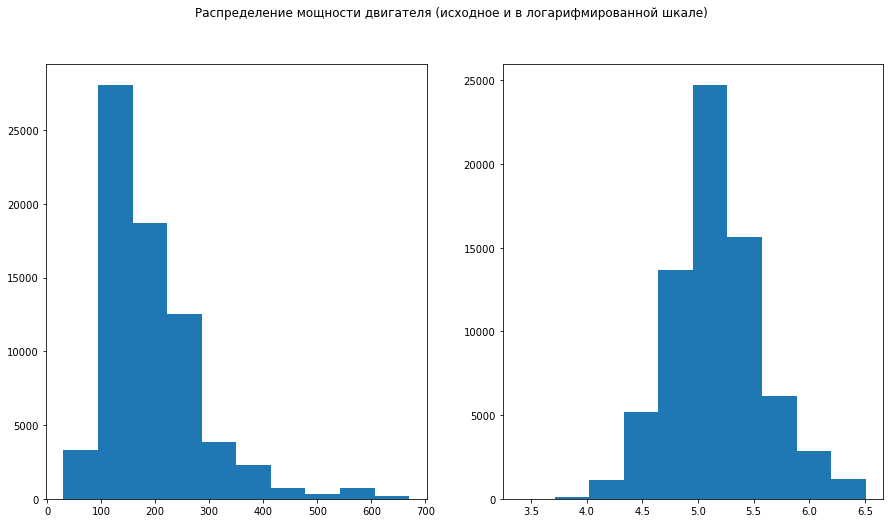

In [93]:
# Прологорифмируем наши значения.
figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
ax1.hist(df.enginePower)
ax2.hist(np.log(df.enginePower))
figure.suptitle('Распределение мощности двигателя (исходное и в логарифмированной шкале)')
plt.show()

**enginePower и engineDisplacement:**

Эти два признака скоррелированы, поэтому нам нужно выбрать один из них. Выше мы проверили - есть ли нулевые значения в `enginePower` и выяснили, что нет. Будем использовать его. То есть учтем электрокары.

**bodyType:**

In [94]:
df.bodyType.value_counts()

внедорожник 5 дв.                   30320
седан                               22866
лифтбек                              5179
хэтчбек 5 дв.                        3642
универсал 5 дв.                      2303
минивэн                              1767
купе                                 1487
компактвэн                            798
хэтчбек 3 дв.                         792
пикап двойная кабина                  548
купе-хардтоп                          215
внедорожник 3 дв.                     203
кабриолет                             173
фургон                                169
родстер                               155
седан-хардтоп                          24
микровэн                               16
пикап одинарная кабина                 12
седан 2 дв.                            10
пикап полуторная кабина                 9
лимузин                                 8
универсал 5 дв. shuttle                 5
внедорожник открытый                    4
седан premio                      

In [95]:
df['bodyType'] = df.bodyType.apply(lambda x: x.split()[0].strip() if isinstance(x, str) else x)

**model_date и prodaction_date:**

Эти признаки скоррелированы, поэтому посмотрим, что из этого нужно выбрать

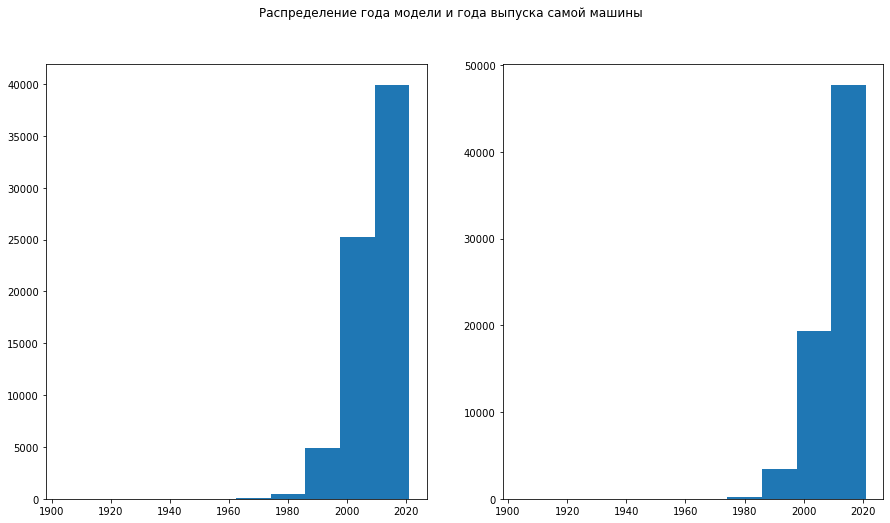

In [96]:
figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
ax1.hist(df.modelDate)
ax2.hist(df.productionDate)
figure.suptitle('Распределение года модели и года выпуска самой машины')
plt.show()

In [97]:
df.columns

Index(['bodyType', 'brand', 'car_url', 'color', 'complectation_dict',
       'description', 'engineDisplacement', 'enginePower', 'equipment_dict',
       'fuelType', 'image', 'mileage', 'modelDate', 'model_info', 'model_name',
       'name', 'numberOfDoors', 'parsing_unixtime', 'priceCurrency',
       'productionDate', 'sell_id', 'super_gen', 'vehicleConfiguration',
       'vehicleTransmission', 'vendor', 'Владельцы', 'Владение', 'ПТС',
       'Привод', 'Руль', 'Состояние', 'Таможня', 'is_train', 'price'],
      dtype='object')

**Учтем разницу цен автомобилей с 2020 по 2021 год, так как цены повысились:**

In [98]:
df.price = df.apply(lambda row: row.price * 0.86, axis=1)

**parsing_unixtime: НЕ ПОЛУЧИЛОСЬ**

In [99]:
# from datetime import datetime
# df['parsing_date'] = ''
# df['parsing_date'] = df['parsing_unixtime'].map(lambda time: datetime.fromtimestamp(int(time)/1000)) # Мы спарсили что-то неправильно. Попробуем поделить на 1000, чтобы привести к удовлетворимому формату.

In [100]:
# # parsing_date
# df['parsing_date'] = pd.to_datetime(df.parsing_unixtime, unit='s')
# df['parsing_date'] = pd.to_datetime(df.parsing_date.dt.floor('d'))

In [101]:
# df['parsing_date'].hist() #Здесь у нас не получилось вытащить требуемые данные, по непонятной причине.

**Удалим признаки `Таможня` и `Состояние`:**

In [102]:
df.drop(labels=['Таможня', 'Состояние'], axis=1, inplace=True)
df.reset_index(drop=True, inplace=True)

**Объединим наши признаки под разные категории:**

In [103]:
num_cols = ['engineDisplacement','enginePower','mileage', 'productionDate', 'description_info'] # Числовые признаки
cat_cols = ['bodyType', 'brand', 'color', 'fuelType', 'model_name','name', 'Привод', 'Владение', 'Владельцы', 'vehicleTransmission','numberOfDoors'] # Категориальные признаки
bin_cols = ['Руль', 'ПТС'] # Бинарные признаки
help_cols = ['is_train', 'parsing_date'] # Вспомогательные признаки
target_col = ['price'] # Целевая переменная

all_cols = cat_cols + num_cols + bin_cols + help_cols + target_col
len(all_cols)

21

<ipython-input-104-757b67845bc9>:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-104-757b67845bc9>:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-104-757b67845bc9>:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-104-757b67845bc9>:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-104-757b67845bc9>:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-104-757b67845bc9>:9: UserWarning: Matplotlib 

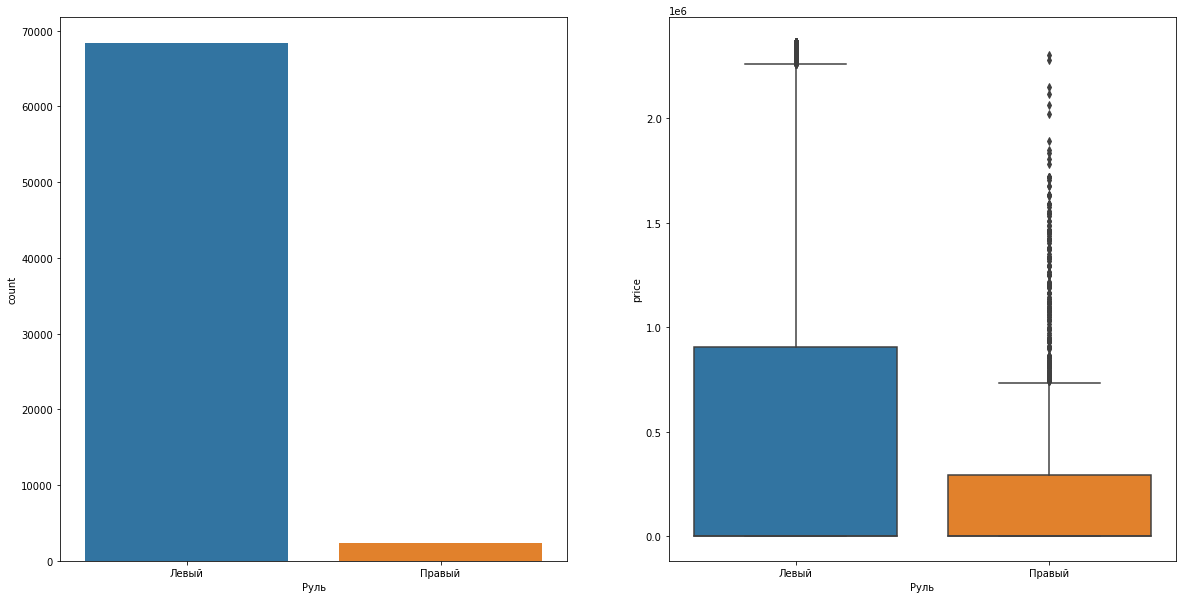

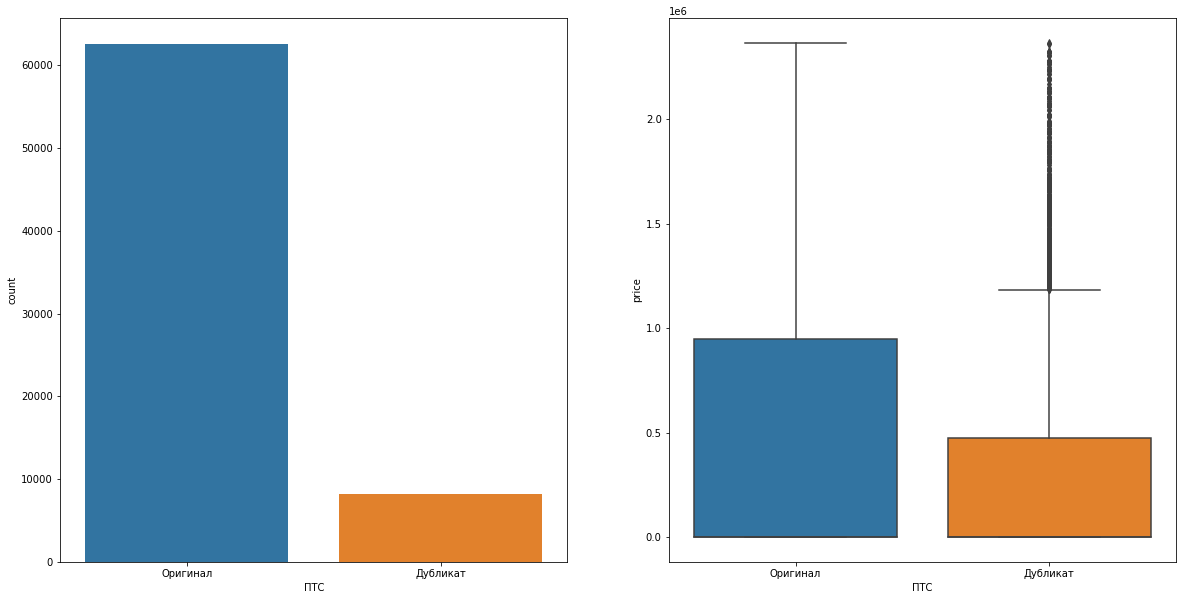

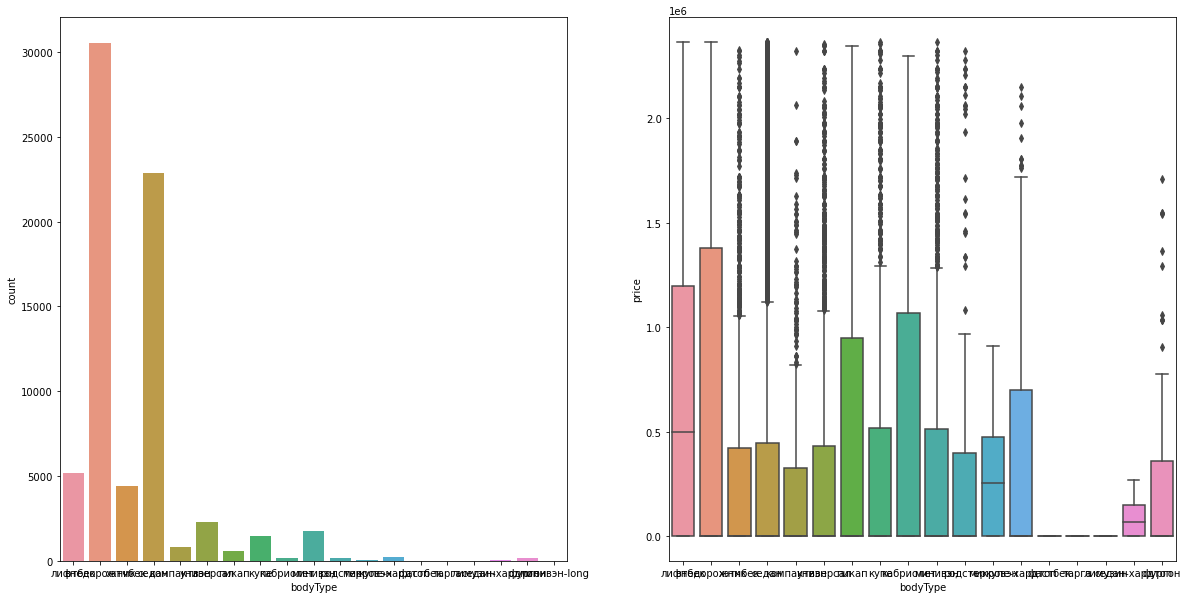

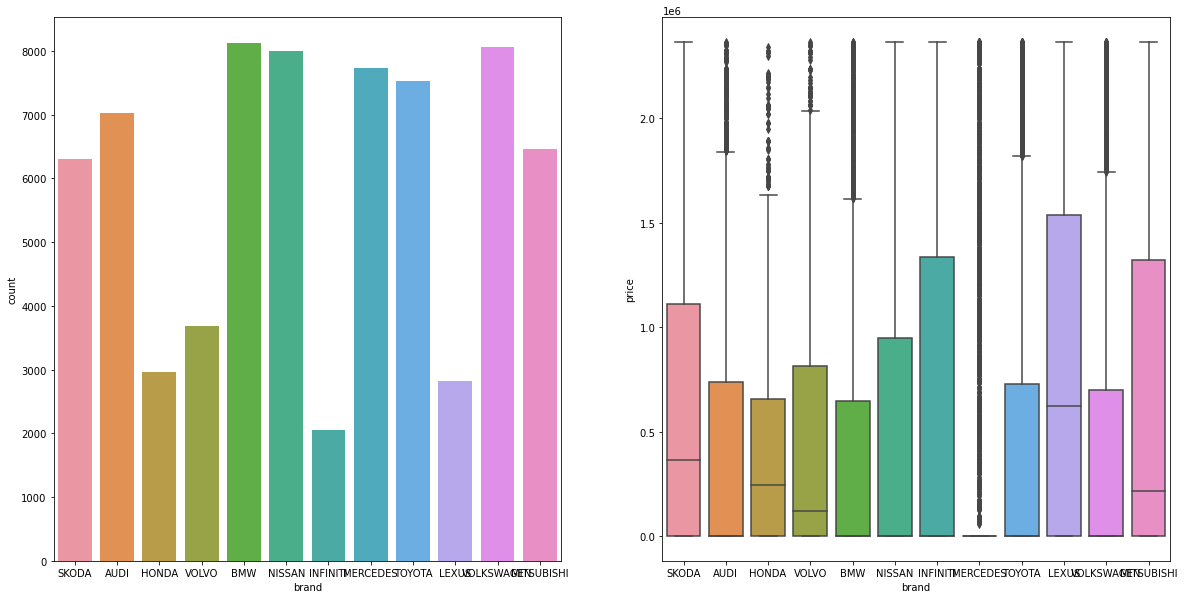

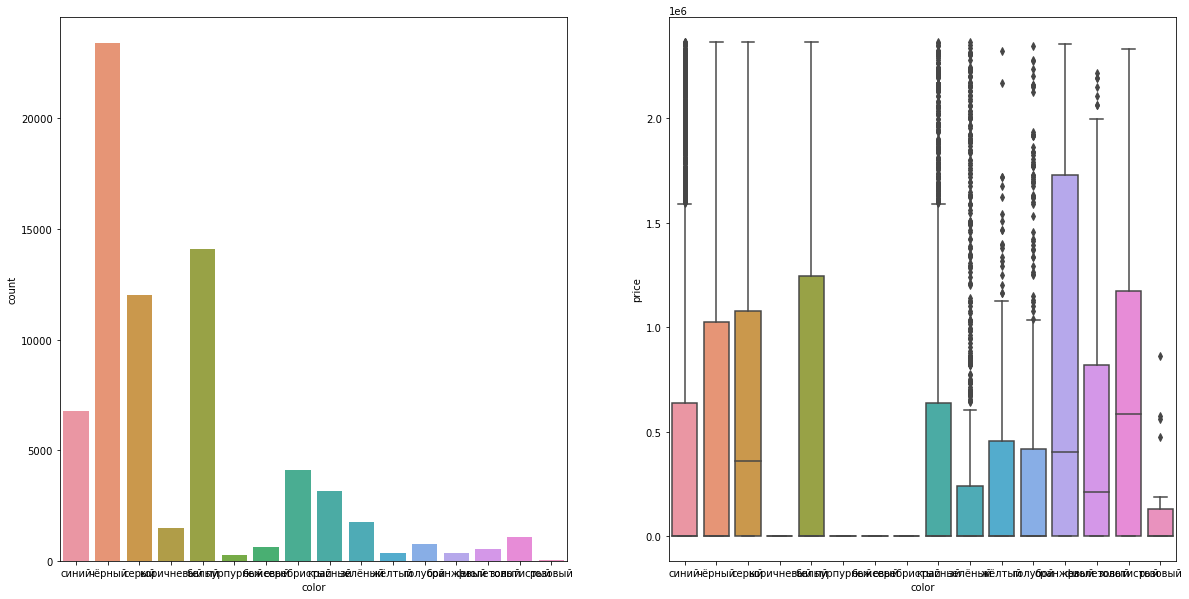

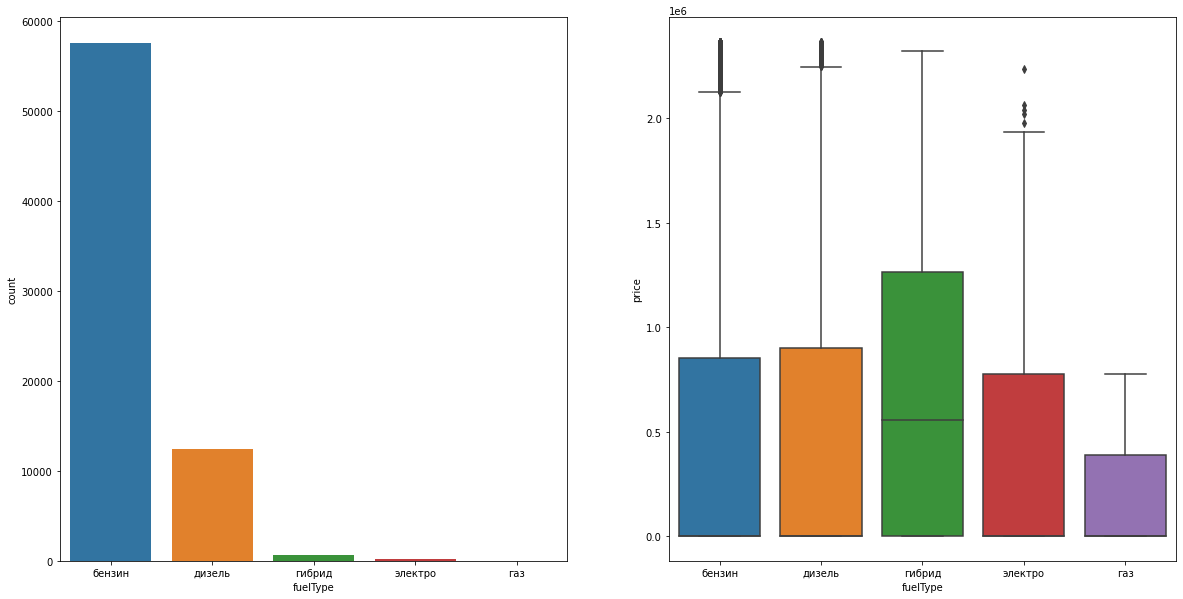

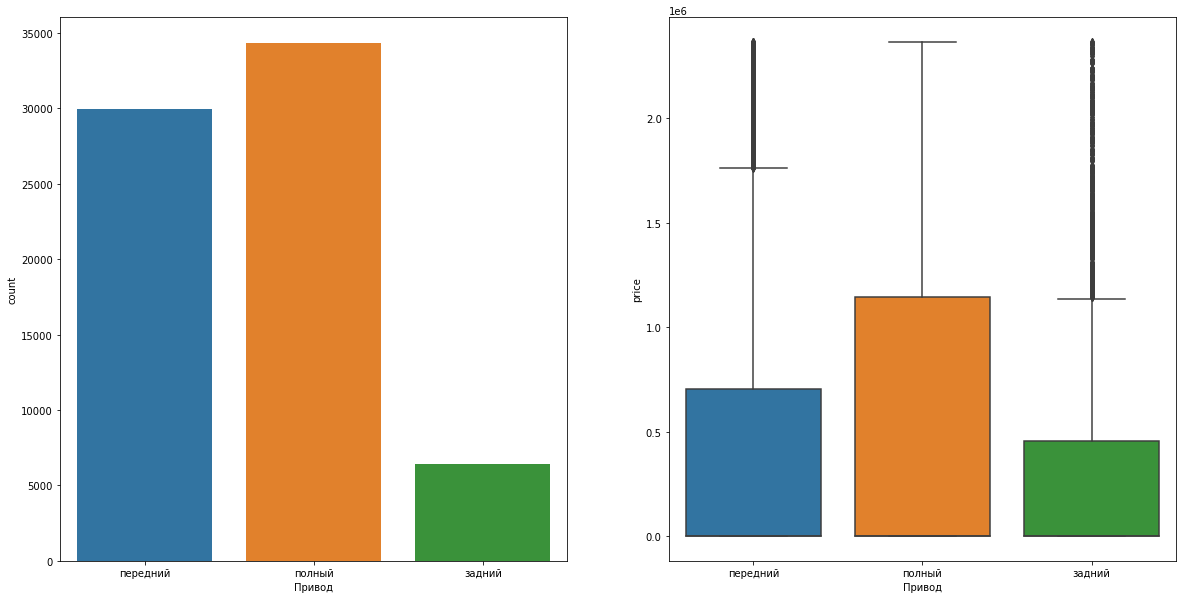

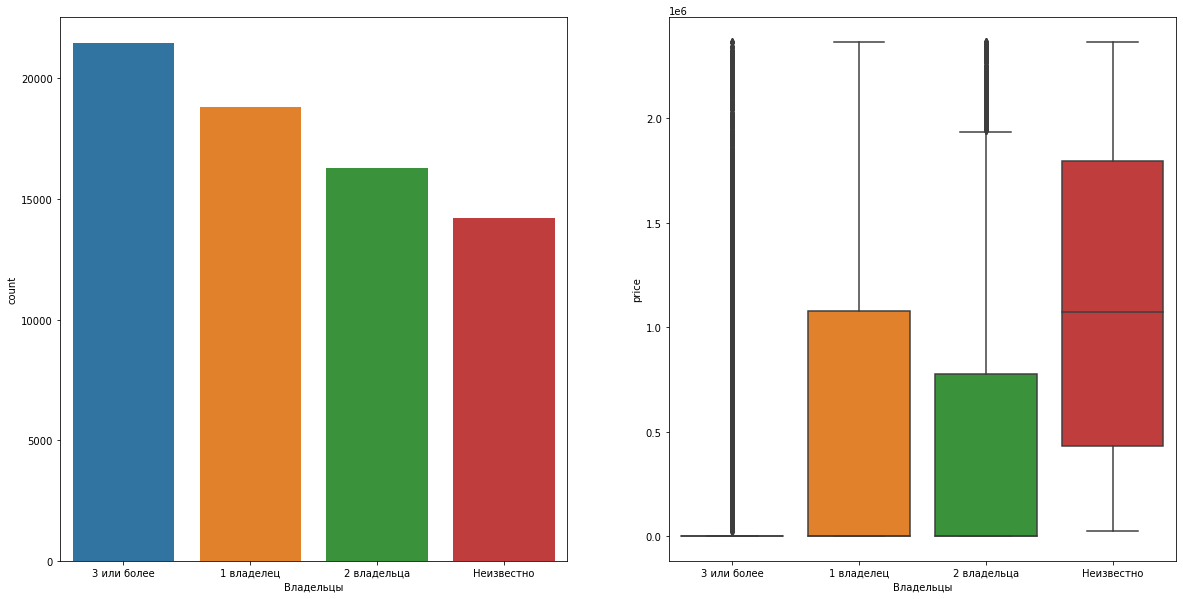

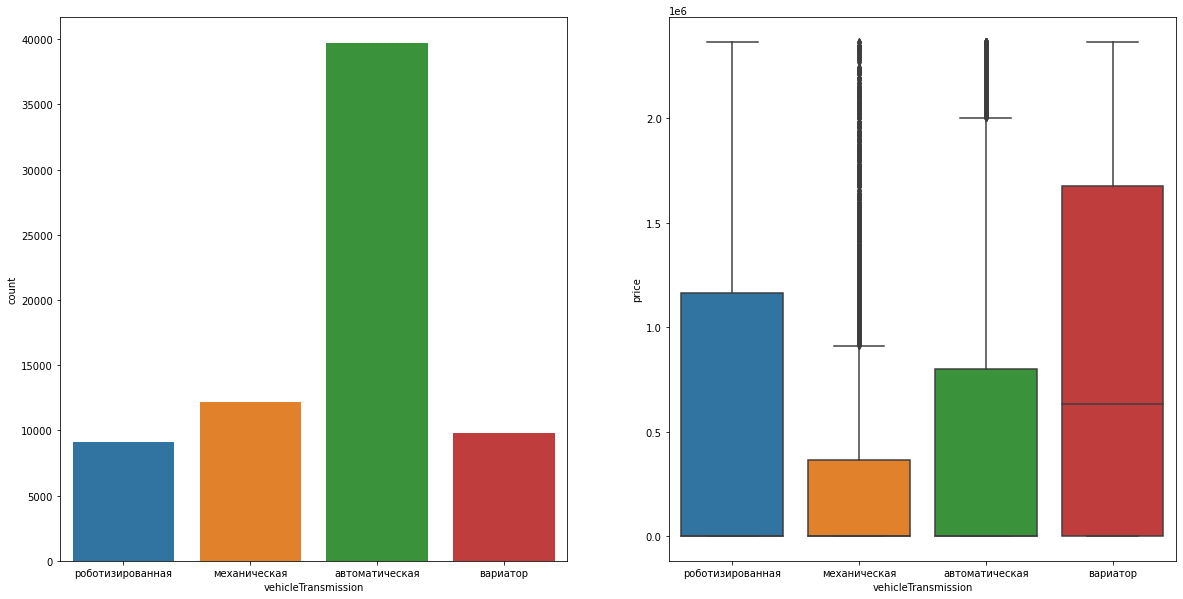

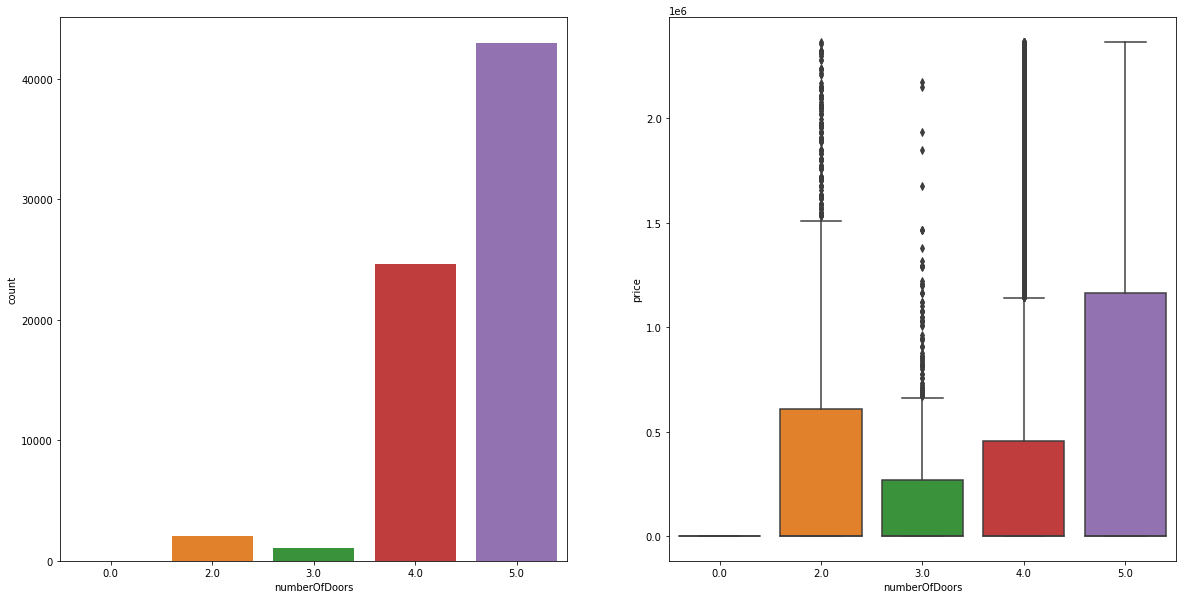

In [104]:
for item in bin_cols + cat_cols:  
    if item not in ['model_name', 'name', 'Владение']: 
        # слишком много значений в этих колонках перегрузят график, сделав его не информативным
        fig, ax =plt.subplots(1,2, figsize=(20,10))
        sns.countplot(x = item, data = df, ax=ax[0])
        # для наглядности анализа распределения цены для значений 
        # признака уберём хвосты задав quantile(0.85)
        sns.boxplot(x=item, y='price', data=df[df['price'] <= df['price'].quantile(0.85)], ax=ax[1])
        fig.show()

**price:**

Text(0.5, 0, 'price, RUB * 10^7')

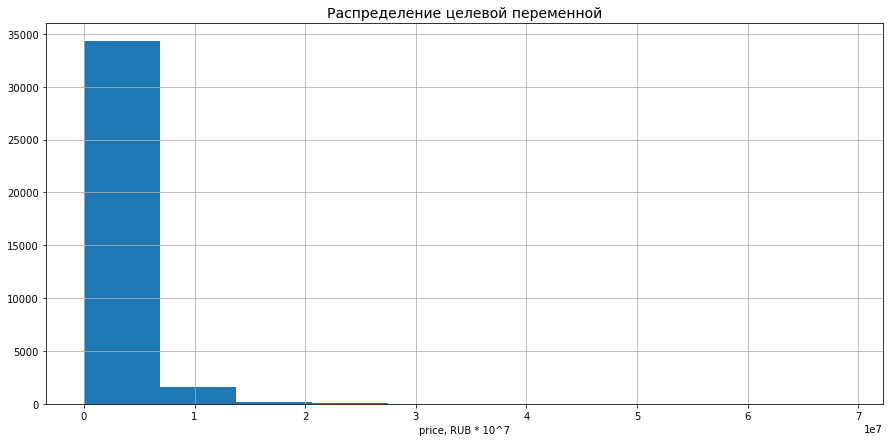

In [105]:
df.query('is_train == 1').price.hist(figsize=(15, 7))
plt.title('Распределение целевой переменной', fontdict={'fontsize': 14})
plt.xlabel('price, RUB * 10^7')

**Логарифмирование:**

In [106]:
df['price_log'] = np.log2(df['price'] + 1)
df['enginePower'] = np.log2(df['enginePower'] + 1)
df['mileage'] = np.log2(df['mileage'] + 1)


# 5. Создание новых признаков:

**1. Создадим отдельный признак (марка 1/0), определяющий обладает ли автомобиль редким цветом или популярным цветом: `rare_color` и `popular_color`.**

In [107]:
popular = df.color.value_counts()[0:5].keys().tolist()
popular

['чёрный', 'белый', 'серый', 'синий', 'серебристый']

In [108]:
df['popular_color'] = df['color'].apply(lambda x: 1 if x in popular else 0)

In [109]:
rare = df.color.value_counts()[-1:-6:-1] #.keys().tolist()
rare

розовый        19
пурпурный     254
жёлтый        361
оранжевый     368
фиолетовый    548
Name: color, dtype: int64

In [110]:
df['rare_color'] = df['color'].apply(lambda x: 1 if x in rare else 0)

**2. Создадим признак - разницу между выпуском и началом производства автомобиля `diff_date_model_production`.**

In [111]:
df['diff_date_model_production'] = df.productionDate-df.modelDate
df['diff_date_model_production_log'] = np.log(df.diff_date_model_production - np.min(df.diff_date_model_production)+1) # пролагорифмируем

**3. Создадим признак с возрастом автомобиля к настоящему времени `age_car`. Создадим признак с пробегом за год `year_mileage`.**

In [112]:
df['age_car'] = 2021 - df.productionDate

In [113]:
df['year_mileage'] = df['mileage']/df['age_car']

In [114]:
df['year_mileage'].value_counts() # Можем увидеть, что самое популярное значение равно inf. Нам это не подходит.

inf         733
1.329825     68
1.342896     67
1.930576     64
1.379352     62
           ... 
1.048617      1
3.990068      1
1.306677      1
2.670218      1
0.585025      1
Name: year_mileage, Length: 31794, dtype: int64

In [115]:
df['year_mileage'].isna().value_counts()

False    62166
True      8558
Name: year_mileage, dtype: int64

In [116]:
df['year_mileage'].replace([np.inf, -np.inf], 0, inplace=True) 

In [117]:
df['year_mileage'].value_counts()

0.000000    792
1.329825     68
1.342896     67
1.930576     64
1.379352     62
           ... 
5.361520      1
1.646522      1
1.896751      1
0.736349      1
1.755930      1
Name: year_mileage, Length: 31793, dtype: int64

In [118]:
df['year_mileage'] = np.log2(df['year_mileage']+1) # Пролагорифмируем полученные признаки
df['age_car'] = np.log2(df['age_car']+1)

In [119]:
df['year_mileage'] = df['year_mileage'].fillna(0.0) # у нас здесь появились пропуски (неизвестно). Заменим их.

**4. Добавим признак `description_info`, чтобы оценить количество символов в описании.**

In [120]:
df['description_info'] = df.description.apply(
    lambda x: len(x) if isinstance(x, str) else x)
df['description_info'] = df['description_info'].fillna(0.0)
df['description_info'] = np.log2(df['description_info'] + 1)

**Оценим важность чиcловых признаков с помощью f_regression:**

<AxesSubplot:>

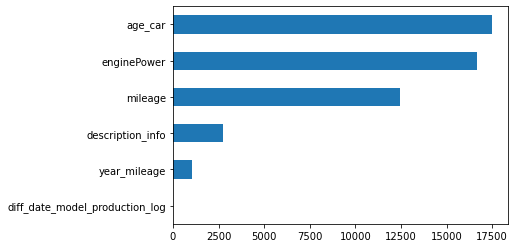

In [121]:
num_cols = ['enginePower', 'mileage', 'diff_date_model_production_log', 'age_car', 'description_info', 'year_mileage']
imp_num = pd.Series(f_regression(
    df[df['is_train'] == 1][num_cols], df[df['is_train'] == 1]['price'])[0], index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')

In [122]:
cat_cols = ['bodyType', 'brand', 'color', 'fuelType', 'model_name','name', 'Привод', 'Владение', 'Владельцы', 'vehicleTransmission','numberOfDoors', 'top_color', 'rare_color'] # Категориальные признаки
bin_cols = ['Руль', 'ПТС'] # Бинарные признаки

In [123]:
# imp_cat = pd.Series(
#     mutual_info_regression(
#         X[X['is_train'] == 1][list(set(df.columns) & set(cat_cols+bin_cols))], 
#         df[df['is_train'] == 1]['price'], 
#         discrete_features=True), index=list(set(df.columns) & set(cat_cols+bin_cols))
# )
# imp_cat.sort_values(inplace=True)
# imp_cat.plot(kind='barh', title='Категориальные и двоичные столбцы')
# plt.show()

# # Здесь не получилось выявить зависимость.

In [124]:
# удалим не нужные столбцы

df.drop(labels=['car_url', 'complectation_dict', 'description', 'equipment_dict', 'image',
                'model_info', 'parsing_unixtime', 'priceCurrency',
                'super_gen', 'vehicleConfiguration', 'vendor'], axis=1, inplace=True)

In [125]:
# Снова рассмотрим наш датасет.
df.isna().sum() # Видим что мы забыли про "Владение".

bodyType                              0
brand                                 0
color                                 0
engineDisplacement                    0
enginePower                           0
fuelType                              0
mileage                               0
modelDate                             0
model_name                            0
name                                  0
numberOfDoors                         0
productionDate                        0
sell_id                               0
vehicleTransmission                   0
Владельцы                             0
Владение                          51141
ПТС                                   0
Привод                                0
Руль                                  0
is_train                              0
price                                 0
price_log                             0
popular_color                         0
rare_color                            0
diff_date_model_production            0


In [126]:
df.loc[df['Владение'].isna(), 'Владение'] = df['age_car'] # Заменим здесь пустые значения соответствуюшими значениями из 'age_car'.

In [127]:
df.columns

Index(['bodyType', 'brand', 'color', 'engineDisplacement', 'enginePower',
       'fuelType', 'mileage', 'modelDate', 'model_name', 'name',
       'numberOfDoors', 'productionDate', 'sell_id', 'vehicleTransmission',
       'Владельцы', 'Владение', 'ПТС', 'Привод', 'Руль', 'is_train', 'price',
       'price_log', 'popular_color', 'rare_color',
       'diff_date_model_production', 'diff_date_model_production_log',
       'age_car', 'year_mileage', 'description_info'],
      dtype='object')

In [128]:
num_cols = ['enginePower', 'mileage', 'diff_date_model_production_log', 'age_car', 'description_info', 'year_mileage'] # Числовые признаки
cat_cols = ['bodyType', 'brand', 'color', 'fuelType', 'model_name','name', 'Привод', 'Владение', 'Владельцы', 'vehicleTransmission','numberOfDoors', 'popular_color', 'rare_color','Руль', 'ПТС'] # Категориальные признаки


len(num_cols+cat_cols)

21

In [129]:
cols_to_encode = list(set(df.columns) & set(cat_cols))
for colum in cols_to_encode:
    df[colum] = df[colum].astype('category').cat.codes

**Оценим важность категориальных переменных с поомщью mutual_info_regression:**

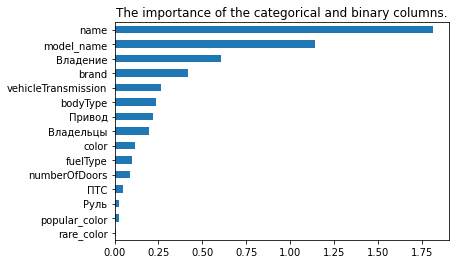

In [130]:
imp_cat = pd.Series(
    mutual_info_regression(
        df[df.is_train == 1][list(set(df.columns) & set(cat_cols))], 
        df[df.is_train == 1]['price'], 
        discrete_features=True), index=list(set(df.columns) & set(cat_cols))
)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh', title='The importance of the categorical and binary columns.')
plt.show()

In [131]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70724 entries, 0 to 70723
Data columns (total 29 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   bodyType                        70724 non-null  int8   
 1   brand                           70724 non-null  int8   
 2   color                           70724 non-null  int8   
 3   engineDisplacement              70724 non-null  float64
 4   enginePower                     70724 non-null  float64
 5   fuelType                        70724 non-null  int8   
 6   mileage                         70724 non-null  float64
 7   modelDate                       70724 non-null  float64
 8   model_name                      70724 non-null  int16  
 9   name                            70724 non-null  int16  
 10  numberOfDoors                   70724 non-null  int8   
 11  productionDate                  70724 non-null  int64  
 12  sell_id                         

# 6. Машинное обучение:

In [133]:
X = df.query('is_train == 1').drop(['price', 'is_train', 'price_log','sell_id'], axis=1)
X_sub = df.query('is_train == 0').drop(['price', 'is_train', 'price_log','sell_id'], axis=1)
y = df.query('is_train == 1').price

In [134]:
def mape(
    y_true: np.ndarray, 
    y_pred: np.ndarray
):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [135]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, shuffle=True, random_state=42)

In [136]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((25226, 25), (10812, 25), (25226,), (10812,))

**RandomForestRegressor 2000:**

In [140]:
# without log-transformation of the target variable
rf = RandomForestRegressor(2000, random_state=RANDOM_SEED, n_jobs=-1, verbose=1)
rf.fit(X_train, y_train)
predict_rf = rf.predict(X_test)

print(f"The MAPE mertics of the Random Forest model using MAPE metrics: {(mape(y_test, predict_rf) * 100):0.2f}%.")

# with log-transformation of the target variable
rf_log = RandomForestRegressor(2000, random_state=RANDOM_SEED, n_jobs=-1, verbose=1)
rf_log.fit(X_train, np.log(y_train))
predict_rf_log = np.exp(rf_log.predict(X_test))

print(f"The MAPE mertic for the Random Forest model is : {(mape(y_test, predict_rf_log) * 100):0.2f}%.")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:   29.5s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done 1218 tasks      | elapsed:    0.9s
[Parallel(n_jobs=16)]: Done 1768 tasks      | elapsed:    1.3s
[Parallel(n_job

The MAPE mertics of the Random Forest model using MAPE metrics: 13.41%.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:   27.9s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done 1218 tasks      | elapsed:    1.2s
[Parallel(n_jobs=16)]: Done 1768 tasks      | elapsed:    1.8s


The MAPE mertic for the Random Forest model is : 11.56%.


[Parallel(n_jobs=16)]: Done 2000 out of 2000 | elapsed:    2.0s finished


**RandomForestRegressor 3000:**

In [139]:
# without log-transformation of the target variable
rf = RandomForestRegressor(3000, random_state=RANDOM_SEED, n_jobs=-1, verbose=1)
rf.fit(X_train, y_train)
predict_rf = rf.predict(X_test)

print(f"The MAPE mertics of the Random Forest model using MAPE metrics: {(mape(y_test, predict_rf) * 100):0.2f}%.")

# with log-transformation of the target variable
rf_log = RandomForestRegressor(3000, random_state=RANDOM_SEED, n_jobs=-1, verbose=1)
rf_log.fit(X_train, np.log(y_train))
predict_rf_log = np.exp(rf_log.predict(X_test))

print(f"The MAPE mertic for the Random Forest model is : {(mape(y_test, predict_rf_log) * 100):0.2f}%.")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:   26.6s
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed:   35.4s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   43.6s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done 1218 tasks      | elapsed:    1.0s
[Parallel(n_job

The MAPE mertics of the Random Forest model using MAPE metrics: 13.42%.


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.5s


The MAPE mertic for the Random Forest model is : 11.66%.


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.6s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished


Вывод: результат лучше при логарифмировании целевой переменной. Повышение количества деревьей не сильно улучшает результат.

**CatBoostRegressor:**

In [145]:
model = CatBoostRegressor(iterations=2000,
                          learning_rate=0.1,
                          random_seed=43,
                          eval_metric='MAPE',
                          cat_features=cat_cols)

    
kf = KFold(n_splits=3, shuffle=True, random_state=43)
cv_results = cross_val_score(model, X, y, cv=kf, n_jobs=-1, scoring=make_scorer(mape))
    

In [146]:
model.fit(X_train,np.log(y_train))
predict_cat = model.predict(X_test)
train_score = mape(y_test, model.predict(X_test))

print()
print(model)
print(f"train shape {X.shape}")
print()
print(f"Train result: {train_score*100}")
print(f'CV result: {np.mean(cv_results)} ({cv_results})')
print()


0:	learn: 0.0511281	total: 310ms	remaining: 10m 19s
1:	learn: 0.0467993	total: 450ms	remaining: 7m 29s
2:	learn: 0.0428923	total: 547ms	remaining: 6m 4s
3:	learn: 0.0394363	total: 682ms	remaining: 5m 40s
4:	learn: 0.0362992	total: 782ms	remaining: 5m 11s
5:	learn: 0.0334755	total: 894ms	remaining: 4m 57s
6:	learn: 0.0308558	total: 981ms	remaining: 4m 39s
7:	learn: 0.0286649	total: 1.04s	remaining: 4m 20s
8:	learn: 0.0267324	total: 1.12s	remaining: 4m 8s
9:	learn: 0.0250113	total: 1.18s	remaining: 3m 54s
10:	learn: 0.0234360	total: 1.28s	remaining: 3m 52s
11:	learn: 0.0220675	total: 1.38s	remaining: 3m 48s
12:	learn: 0.0208410	total: 1.46s	remaining: 3m 42s
13:	learn: 0.0197169	total: 1.53s	remaining: 3m 36s
14:	learn: 0.0187001	total: 1.66s	remaining: 3m 40s
15:	learn: 0.0178855	total: 1.72s	remaining: 3m 32s
16:	learn: 0.0171097	total: 1.8s	remaining: 3m 29s
17:	learn: 0.0164562	total: 1.87s	remaining: 3m 25s
18:	learn: 0.0158853	total: 1.93s	remaining: 3m 20s
19:	learn: 0.0154096	tot

158:	learn: 0.0093232	total: 13.5s	remaining: 2m 36s
159:	learn: 0.0093090	total: 13.5s	remaining: 2m 35s
160:	learn: 0.0092949	total: 13.6s	remaining: 2m 35s
161:	learn: 0.0092892	total: 13.7s	remaining: 2m 35s
162:	learn: 0.0092872	total: 13.8s	remaining: 2m 35s
163:	learn: 0.0092755	total: 13.9s	remaining: 2m 35s
164:	learn: 0.0092497	total: 13.9s	remaining: 2m 35s
165:	learn: 0.0092455	total: 14s	remaining: 2m 35s
166:	learn: 0.0092359	total: 14.1s	remaining: 2m 34s
167:	learn: 0.0092321	total: 14.2s	remaining: 2m 34s
168:	learn: 0.0092199	total: 14.3s	remaining: 2m 34s
169:	learn: 0.0091969	total: 14.4s	remaining: 2m 34s
170:	learn: 0.0091798	total: 14.5s	remaining: 2m 34s
171:	learn: 0.0091737	total: 14.5s	remaining: 2m 34s
172:	learn: 0.0091627	total: 14.6s	remaining: 2m 34s
173:	learn: 0.0091470	total: 14.7s	remaining: 2m 34s
174:	learn: 0.0091276	total: 14.8s	remaining: 2m 34s
175:	learn: 0.0091168	total: 14.8s	remaining: 2m 33s
176:	learn: 0.0091131	total: 14.9s	remaining: 2m

314:	learn: 0.0082731	total: 25.5s	remaining: 2m 16s
315:	learn: 0.0082665	total: 25.6s	remaining: 2m 16s
316:	learn: 0.0082650	total: 25.6s	remaining: 2m 16s
317:	learn: 0.0082619	total: 25.7s	remaining: 2m 15s
318:	learn: 0.0082531	total: 25.8s	remaining: 2m 15s
319:	learn: 0.0082484	total: 25.9s	remaining: 2m 15s
320:	learn: 0.0082303	total: 26s	remaining: 2m 15s
321:	learn: 0.0082275	total: 26.1s	remaining: 2m 15s
322:	learn: 0.0082185	total: 26.2s	remaining: 2m 15s
323:	learn: 0.0082143	total: 26.2s	remaining: 2m 15s
324:	learn: 0.0082079	total: 26.3s	remaining: 2m 15s
325:	learn: 0.0082057	total: 26.4s	remaining: 2m 15s
326:	learn: 0.0082049	total: 26.4s	remaining: 2m 15s
327:	learn: 0.0082017	total: 26.5s	remaining: 2m 15s
328:	learn: 0.0082005	total: 26.6s	remaining: 2m 15s
329:	learn: 0.0081989	total: 26.7s	remaining: 2m 14s
330:	learn: 0.0081976	total: 26.7s	remaining: 2m 14s
331:	learn: 0.0081959	total: 26.8s	remaining: 2m 14s
332:	learn: 0.0081865	total: 26.9s	remaining: 2m

473:	learn: 0.0077876	total: 37.4s	remaining: 2m
474:	learn: 0.0077854	total: 37.5s	remaining: 2m
475:	learn: 0.0077809	total: 37.5s	remaining: 2m
476:	learn: 0.0077718	total: 37.6s	remaining: 2m
477:	learn: 0.0077691	total: 37.7s	remaining: 1m 59s
478:	learn: 0.0077637	total: 37.7s	remaining: 1m 59s
479:	learn: 0.0077527	total: 37.8s	remaining: 1m 59s
480:	learn: 0.0077509	total: 37.9s	remaining: 1m 59s
481:	learn: 0.0077497	total: 37.9s	remaining: 1m 59s
482:	learn: 0.0077480	total: 38s	remaining: 1m 59s
483:	learn: 0.0077453	total: 38.1s	remaining: 1m 59s
484:	learn: 0.0077424	total: 38.1s	remaining: 1m 59s
485:	learn: 0.0077416	total: 38.2s	remaining: 1m 58s
486:	learn: 0.0077414	total: 38.3s	remaining: 1m 58s
487:	learn: 0.0077391	total: 38.3s	remaining: 1m 58s
488:	learn: 0.0077374	total: 38.4s	remaining: 1m 58s
489:	learn: 0.0077349	total: 38.5s	remaining: 1m 58s
490:	learn: 0.0077313	total: 38.5s	remaining: 1m 58s
491:	learn: 0.0077280	total: 38.6s	remaining: 1m 58s
492:	learn:

631:	learn: 0.0073611	total: 49.4s	remaining: 1m 46s
632:	learn: 0.0073590	total: 49.5s	remaining: 1m 46s
633:	learn: 0.0073549	total: 49.5s	remaining: 1m 46s
634:	learn: 0.0073523	total: 49.6s	remaining: 1m 46s
635:	learn: 0.0073482	total: 49.7s	remaining: 1m 46s
636:	learn: 0.0073452	total: 49.8s	remaining: 1m 46s
637:	learn: 0.0073451	total: 49.9s	remaining: 1m 46s
638:	learn: 0.0073445	total: 50s	remaining: 1m 46s
639:	learn: 0.0073440	total: 50.1s	remaining: 1m 46s
640:	learn: 0.0073434	total: 50.2s	remaining: 1m 46s
641:	learn: 0.0073421	total: 50.3s	remaining: 1m 46s
642:	learn: 0.0073393	total: 50.4s	remaining: 1m 46s
643:	learn: 0.0073382	total: 50.5s	remaining: 1m 46s
644:	learn: 0.0073373	total: 50.6s	remaining: 1m 46s
645:	learn: 0.0073344	total: 50.6s	remaining: 1m 46s
646:	learn: 0.0073340	total: 50.7s	remaining: 1m 46s
647:	learn: 0.0073326	total: 50.8s	remaining: 1m 45s
648:	learn: 0.0073299	total: 50.9s	remaining: 1m 45s
649:	learn: 0.0073268	total: 51s	remaining: 1m 4

789:	learn: 0.0070819	total: 1m 2s	remaining: 1m 35s
790:	learn: 0.0070805	total: 1m 2s	remaining: 1m 34s
791:	learn: 0.0070795	total: 1m 2s	remaining: 1m 34s
792:	learn: 0.0070773	total: 1m 2s	remaining: 1m 34s
793:	learn: 0.0070755	total: 1m 2s	remaining: 1m 34s
794:	learn: 0.0070743	total: 1m 2s	remaining: 1m 34s
795:	learn: 0.0070725	total: 1m 2s	remaining: 1m 34s
796:	learn: 0.0070700	total: 1m 2s	remaining: 1m 34s
797:	learn: 0.0070671	total: 1m 2s	remaining: 1m 34s
798:	learn: 0.0070662	total: 1m 2s	remaining: 1m 34s
799:	learn: 0.0070658	total: 1m 2s	remaining: 1m 34s
800:	learn: 0.0070653	total: 1m 2s	remaining: 1m 34s
801:	learn: 0.0070636	total: 1m 2s	remaining: 1m 33s
802:	learn: 0.0070617	total: 1m 2s	remaining: 1m 33s
803:	learn: 0.0070603	total: 1m 3s	remaining: 1m 33s
804:	learn: 0.0070584	total: 1m 3s	remaining: 1m 33s
805:	learn: 0.0070577	total: 1m 3s	remaining: 1m 33s
806:	learn: 0.0070568	total: 1m 3s	remaining: 1m 33s
807:	learn: 0.0070527	total: 1m 3s	remaining: 

945:	learn: 0.0068564	total: 1m 12s	remaining: 1m 21s
946:	learn: 0.0068554	total: 1m 12s	remaining: 1m 21s
947:	learn: 0.0068538	total: 1m 13s	remaining: 1m 21s
948:	learn: 0.0068523	total: 1m 13s	remaining: 1m 20s
949:	learn: 0.0068521	total: 1m 13s	remaining: 1m 20s
950:	learn: 0.0068510	total: 1m 13s	remaining: 1m 20s
951:	learn: 0.0068508	total: 1m 13s	remaining: 1m 20s
952:	learn: 0.0068504	total: 1m 13s	remaining: 1m 20s
953:	learn: 0.0068496	total: 1m 13s	remaining: 1m 20s
954:	learn: 0.0068491	total: 1m 13s	remaining: 1m 20s
955:	learn: 0.0068480	total: 1m 13s	remaining: 1m 20s
956:	learn: 0.0068470	total: 1m 13s	remaining: 1m 20s
957:	learn: 0.0068444	total: 1m 13s	remaining: 1m 20s
958:	learn: 0.0068431	total: 1m 13s	remaining: 1m 20s
959:	learn: 0.0068427	total: 1m 13s	remaining: 1m 20s
960:	learn: 0.0068423	total: 1m 13s	remaining: 1m 19s
961:	learn: 0.0068421	total: 1m 14s	remaining: 1m 19s
962:	learn: 0.0068410	total: 1m 14s	remaining: 1m 19s
963:	learn: 0.0068384	total:

1096:	learn: 0.0066565	total: 1m 24s	remaining: 1m 9s
1097:	learn: 0.0066549	total: 1m 24s	remaining: 1m 9s
1098:	learn: 0.0066513	total: 1m 24s	remaining: 1m 9s
1099:	learn: 0.0066511	total: 1m 24s	remaining: 1m 9s
1100:	learn: 0.0066496	total: 1m 24s	remaining: 1m 9s
1101:	learn: 0.0066491	total: 1m 24s	remaining: 1m 9s
1102:	learn: 0.0066488	total: 1m 24s	remaining: 1m 9s
1103:	learn: 0.0066478	total: 1m 25s	remaining: 1m 9s
1104:	learn: 0.0066465	total: 1m 25s	remaining: 1m 9s
1105:	learn: 0.0066462	total: 1m 25s	remaining: 1m 8s
1106:	learn: 0.0066449	total: 1m 25s	remaining: 1m 8s
1107:	learn: 0.0066444	total: 1m 25s	remaining: 1m 8s
1108:	learn: 0.0066436	total: 1m 25s	remaining: 1m 8s
1109:	learn: 0.0066421	total: 1m 25s	remaining: 1m 8s
1110:	learn: 0.0066411	total: 1m 25s	remaining: 1m 8s
1111:	learn: 0.0066410	total: 1m 25s	remaining: 1m 8s
1112:	learn: 0.0066398	total: 1m 25s	remaining: 1m 8s
1113:	learn: 0.0066397	total: 1m 25s	remaining: 1m 8s
1114:	learn: 0.0066394	total

1250:	learn: 0.0064767	total: 1m 36s	remaining: 57.9s
1251:	learn: 0.0064753	total: 1m 36s	remaining: 57.8s
1252:	learn: 0.0064750	total: 1m 36s	remaining: 57.8s
1253:	learn: 0.0064736	total: 1m 36s	remaining: 57.7s
1254:	learn: 0.0064721	total: 1m 37s	remaining: 57.6s
1255:	learn: 0.0064708	total: 1m 37s	remaining: 57.5s
1256:	learn: 0.0064706	total: 1m 37s	remaining: 57.5s
1257:	learn: 0.0064699	total: 1m 37s	remaining: 57.4s
1258:	learn: 0.0064693	total: 1m 37s	remaining: 57.3s
1259:	learn: 0.0064683	total: 1m 37s	remaining: 57.2s
1260:	learn: 0.0064669	total: 1m 37s	remaining: 57.1s
1261:	learn: 0.0064662	total: 1m 37s	remaining: 57s
1262:	learn: 0.0064653	total: 1m 37s	remaining: 57s
1263:	learn: 0.0064645	total: 1m 37s	remaining: 56.9s
1264:	learn: 0.0064636	total: 1m 37s	remaining: 56.8s
1265:	learn: 0.0064628	total: 1m 37s	remaining: 56.7s
1266:	learn: 0.0064618	total: 1m 37s	remaining: 56.6s
1267:	learn: 0.0064612	total: 1m 37s	remaining: 56.6s
1268:	learn: 0.0064600	total: 1m

1404:	learn: 0.0063237	total: 1m 47s	remaining: 45.7s
1405:	learn: 0.0063214	total: 1m 47s	remaining: 45.6s
1406:	learn: 0.0063201	total: 1m 48s	remaining: 45.5s
1407:	learn: 0.0063199	total: 1m 48s	remaining: 45.4s
1408:	learn: 0.0063190	total: 1m 48s	remaining: 45.4s
1409:	learn: 0.0063181	total: 1m 48s	remaining: 45.3s
1410:	learn: 0.0063178	total: 1m 48s	remaining: 45.2s
1411:	learn: 0.0063175	total: 1m 48s	remaining: 45.1s
1412:	learn: 0.0063169	total: 1m 48s	remaining: 45.1s
1413:	learn: 0.0063165	total: 1m 48s	remaining: 45s
1414:	learn: 0.0063153	total: 1m 48s	remaining: 44.9s
1415:	learn: 0.0063150	total: 1m 48s	remaining: 44.8s
1416:	learn: 0.0063136	total: 1m 48s	remaining: 44.7s
1417:	learn: 0.0063134	total: 1m 48s	remaining: 44.7s
1418:	learn: 0.0063120	total: 1m 48s	remaining: 44.6s
1419:	learn: 0.0063112	total: 1m 48s	remaining: 44.5s
1420:	learn: 0.0063093	total: 1m 49s	remaining: 44.4s
1421:	learn: 0.0063081	total: 1m 49s	remaining: 44.4s
1422:	learn: 0.0063076	total: 

1559:	learn: 0.0061879	total: 1m 59s	remaining: 33.8s
1560:	learn: 0.0061877	total: 2m	remaining: 33.8s
1561:	learn: 0.0061866	total: 2m	remaining: 33.7s
1562:	learn: 0.0061861	total: 2m	remaining: 33.6s
1563:	learn: 0.0061841	total: 2m	remaining: 33.5s
1564:	learn: 0.0061838	total: 2m	remaining: 33.5s
1565:	learn: 0.0061831	total: 2m	remaining: 33.4s
1566:	learn: 0.0061827	total: 2m	remaining: 33.3s
1567:	learn: 0.0061820	total: 2m	remaining: 33.2s
1568:	learn: 0.0061814	total: 2m	remaining: 33.2s
1569:	learn: 0.0061810	total: 2m	remaining: 33.1s
1570:	learn: 0.0061808	total: 2m	remaining: 33s
1571:	learn: 0.0061804	total: 2m	remaining: 32.9s
1572:	learn: 0.0061799	total: 2m 1s	remaining: 32.8s
1573:	learn: 0.0061795	total: 2m 1s	remaining: 32.8s
1574:	learn: 0.0061767	total: 2m 1s	remaining: 32.7s
1575:	learn: 0.0061760	total: 2m 1s	remaining: 32.6s
1576:	learn: 0.0061754	total: 2m 1s	remaining: 32.5s
1577:	learn: 0.0061746	total: 2m 1s	remaining: 32.4s
1578:	learn: 0.0061737	total: 

1718:	learn: 0.0060465	total: 2m 11s	remaining: 21.5s
1719:	learn: 0.0060458	total: 2m 11s	remaining: 21.4s
1720:	learn: 0.0060454	total: 2m 11s	remaining: 21.4s
1721:	learn: 0.0060442	total: 2m 11s	remaining: 21.3s
1722:	learn: 0.0060435	total: 2m 11s	remaining: 21.2s
1723:	learn: 0.0060429	total: 2m 11s	remaining: 21.1s
1724:	learn: 0.0060428	total: 2m 12s	remaining: 21s
1725:	learn: 0.0060424	total: 2m 12s	remaining: 21s
1726:	learn: 0.0060416	total: 2m 12s	remaining: 20.9s
1727:	learn: 0.0060413	total: 2m 12s	remaining: 20.8s
1728:	learn: 0.0060405	total: 2m 12s	remaining: 20.8s
1729:	learn: 0.0060396	total: 2m 12s	remaining: 20.7s
1730:	learn: 0.0060386	total: 2m 12s	remaining: 20.6s
1731:	learn: 0.0060366	total: 2m 12s	remaining: 20.5s
1732:	learn: 0.0060364	total: 2m 12s	remaining: 20.4s
1733:	learn: 0.0060355	total: 2m 12s	remaining: 20.4s
1734:	learn: 0.0060347	total: 2m 12s	remaining: 20.3s
1735:	learn: 0.0060335	total: 2m 12s	remaining: 20.2s
1736:	learn: 0.0060320	total: 2m

1872:	learn: 0.0059150	total: 2m 23s	remaining: 9.7s
1873:	learn: 0.0059148	total: 2m 23s	remaining: 9.62s
1874:	learn: 0.0059142	total: 2m 23s	remaining: 9.55s
1875:	learn: 0.0059142	total: 2m 23s	remaining: 9.47s
1876:	learn: 0.0059128	total: 2m 23s	remaining: 9.4s
1877:	learn: 0.0059118	total: 2m 23s	remaining: 9.32s
1878:	learn: 0.0059115	total: 2m 23s	remaining: 9.25s
1879:	learn: 0.0059114	total: 2m 23s	remaining: 9.17s
1880:	learn: 0.0059105	total: 2m 23s	remaining: 9.09s
1881:	learn: 0.0059101	total: 2m 23s	remaining: 9.02s
1882:	learn: 0.0059099	total: 2m 23s	remaining: 8.94s
1883:	learn: 0.0059090	total: 2m 24s	remaining: 8.87s
1884:	learn: 0.0059085	total: 2m 24s	remaining: 8.79s
1885:	learn: 0.0059079	total: 2m 24s	remaining: 8.71s
1886:	learn: 0.0059064	total: 2m 24s	remaining: 8.63s
1887:	learn: 0.0059056	total: 2m 24s	remaining: 8.56s
1888:	learn: 0.0059031	total: 2m 24s	remaining: 8.48s
1889:	learn: 0.0059018	total: 2m 24s	remaining: 8.41s
1890:	learn: 0.0059010	total: 

Вывод: результат оказался не лучше RandomForestRegressor.

**XGBoostRegressor:**

In [148]:
XGBmodel = xgb.XGBRegressor(objective='reg:squarederror', 
                          colsample_bytree=0.5,
                          learning_rate=0.1, 
                          max_depth=12, 
                          alpha=1,
                          n_estimators=2000, 
                          silent=1)

In [149]:
XGBmodel.fit(X_train,y_train)
train_score = mape(y_test, model.predict(X_test))

print()
print(model)
print(f"train shape {X.shape}")
print()
print(f"Train result: {train_score}")
print(f'CV result: {np.mean(cv_results)} ({cv_results})')
print()

[00:21:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.



train shape (36038, 25)

Train result: 0.9999832660641735
CV result: 0.12976698941243878 ([0.13258707 0.12763208 0.12908182])



**StackingRegressor:**

In [147]:
estimators = [
    ('etr', ExtraTreesRegressor(random_state=RANDOM_SEED, n_jobs=-1, verbose=1)),
    ('xgb', xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.5, learning_rate=0.05, max_depth=12, alpha=1, n_jobs=-1, n_estimators=1000, random_state=RANDOM_SEED))
]

sr_log = StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression()
)

# For training, fit() is used
rf_log.fit(X_train, np.log(y_train))

# For MAPE metric (or any other), we need the predictions of the model
y_pred = np.exp(sr_log.predict(X_test))

print(f"The MAPE mertic for the default StackingRegressor model: {(mape(y_test, y_pred) * 100):0.2f}%.")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n

The MAPE mertic for the default StackingRegressor model: 10.82%.


**По итогу лучший результат показал RandomForest.**

In [150]:
predict_submission = np.exp(rf_log.predict(X_sub))
sample_submission['price'] = predict_submission
sample_submission.to_csv(f'final.csv', index=False)
sample_submission.head(10)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.1s finished


,sell_id,price
0,1100575026,7.612863e+05
1,1100549428,1.149161e+06
2,1100658222,1.009213e+06
3,1100937408,8.764775e+05
4,1101037972,8.586159e+05
5,1100912634,8.068041e+05
6,1101228730,7.660293e+05
7,1100165896,4.301692e+05
8,1100768262,2.196910e+06
9,1101218501,8.936784e+05


# 7. Выводы по работе:

По итогу по метрике MAPE выиграл RandomForestRegressor2000.

Свою работу автор оценивает неудовлетворительно из-за недостатка рабочего времени и углубления в проект. Была проведена плохая работа с парсингом (много дублирующихся данных и т.д.). Признаки были в некоторых местах плохо обработаны. Возможно недостаточно новых признаков было создано из уже имеющихся. Кодировка категориальных признаков скорее всего была выполнена некорректна. Настройка моделей не проведена. Но результат показал себя лучше чем baseline модель.